In [ ]:
# mount drive with files

from google.colab import drive
drive.mount('/content/drive')

# install monai

!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.3 MB/s eta 0:00:00


In [ ]:
# import libraries

import os
import shutil
import tempfile
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import nibabel as nib
import time

from monai.losses import DiceCELoss, GeneralizedDiceLoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AddChanneld,
    Compose,
    LoadImaged,
    ScaleIntensityd,
    RandGaussianNoised,
    RandGaussianSmoothd,
    RandAffined,
    ToTensord,
    RandGibbsNoised,

)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet

from monai.data import (
    DataLoader,
    SmartCacheDataset,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


# switch off warning messages
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# set dimensions of the input images (160x160x160) and number of classes (number of labels + background)
img_dim=128
lab_num=1
class_num=lab_num+1


degree_min = -1
degree_max = 1

roi_type="face_"


split_JSON = "face-training-1-lab-v1.json"
split_JSON_run = "face-training-1-lab-v1.json"


root_dir='/content/drive/MyDrive/face-seg-project-2023/new-training-062023/'
data_dir = '/content/drive/MyDrive/face-seg-project-2023/new-training-062023/'

print(root_dir)
os.chdir(root_dir)

/content/drive/MyDrive/face-seg-project-2023/new-training-062023/


In [ ]:
# define data loaders and augmentation for training and validation

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityd(
            keys=["image"], minv=0.0, maxv=1.0
        ),

        RandGaussianSmoothd(keys=["image"], sigma_x = (0.7, 1.0), sigma_y = (0.7, 1.0), sigma_z = (0.7, 1.0), prob=0.1, allow_missing_keys=False),

        RandKSpaceSpikeNoised(keys=["image"], prob=0.3, intensity_range=(1.0, 1.5), allow_missing_keys=False),

        RandGibbsNoised(keys=["image"], alpha=(0.3,0.5), allow_missing_keys=False, prob=0.05),

        RandAffined(
            keys=["image", "label"],
            rotate_range=[(degree_min,degree_max),(degree_min,degree_max),(degree_min,degree_max)],
            mode=("bilinear", "nearest"),
            padding_mode=("zeros"),
            prob=0.9,
        ),
        ToTensord(keys=["image", "label"]),

    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityd(
            keys=["image"], minv=0.0, maxv=1.0
        ),
        ToTensord(keys=["image", "label"]),
    ]
)




In [ ]:
# load the files based on the lists in json

datasets = data_dir + split_JSON

datalist = load_decathlon_datalist(datasets, True, "training")

train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=200,
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=True, num_workers=4, pin_memory=True
)

val_files = load_decathlon_datalist(datasets, True, "validation")
val_ds = CacheDataset(
    data=val_files,
    transform=val_transforms,
    cache_num=80,
    cache_rate=1.0,
    num_workers=4
)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True
)


Loading dataset: 100%|██████████| 12/12 [00:04<00:00,  2.59it/s]


0 261-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


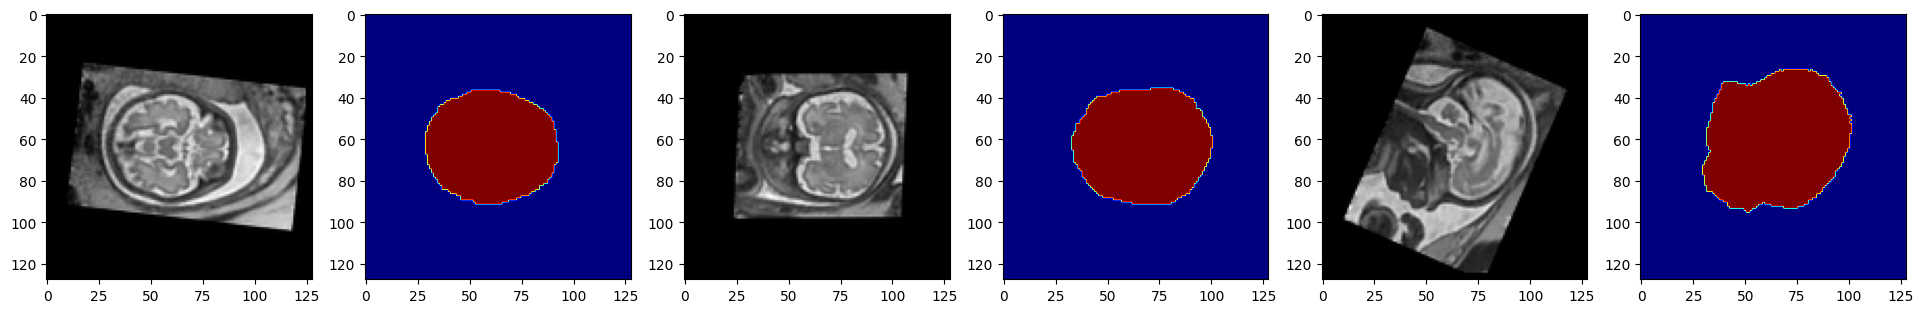

1 335-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


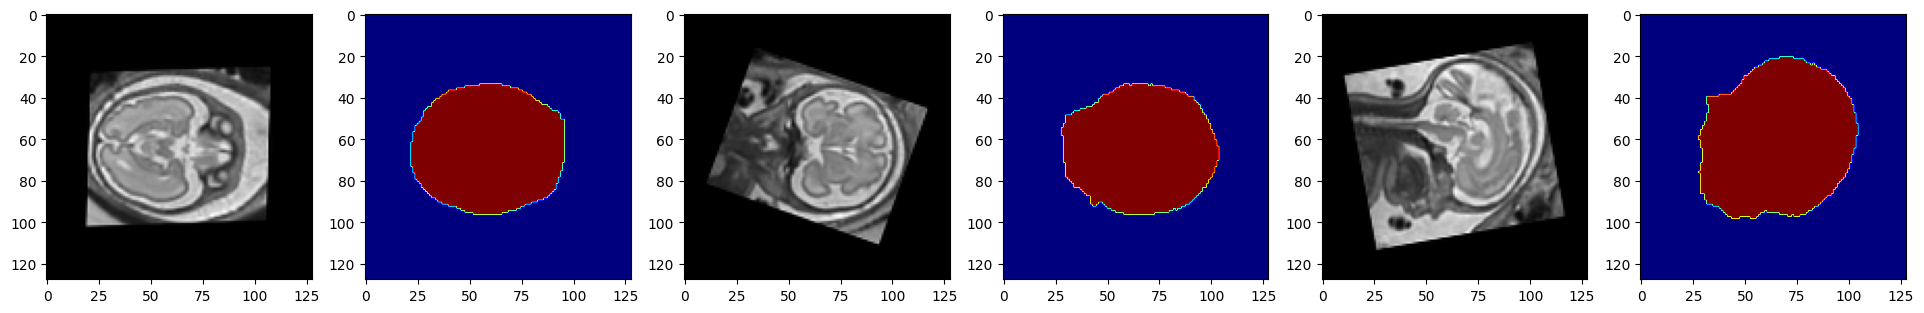

2 426-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


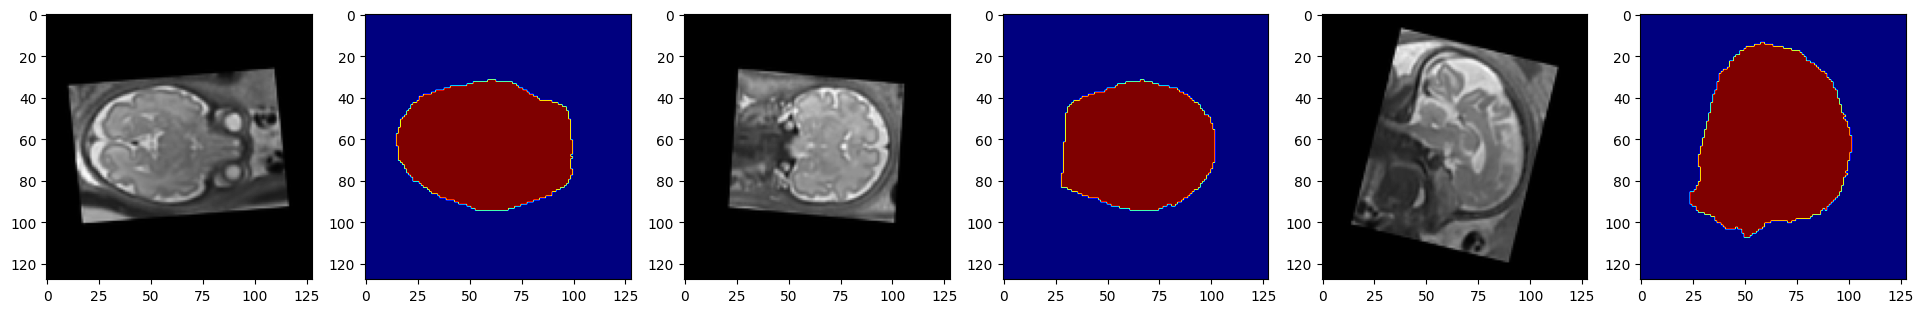

3 342-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


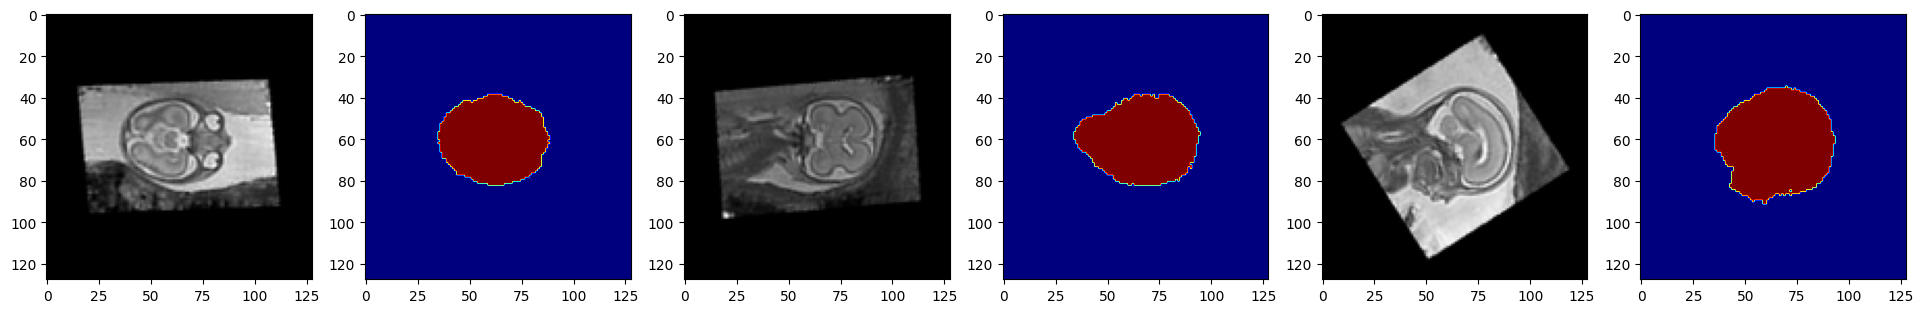

4 435-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


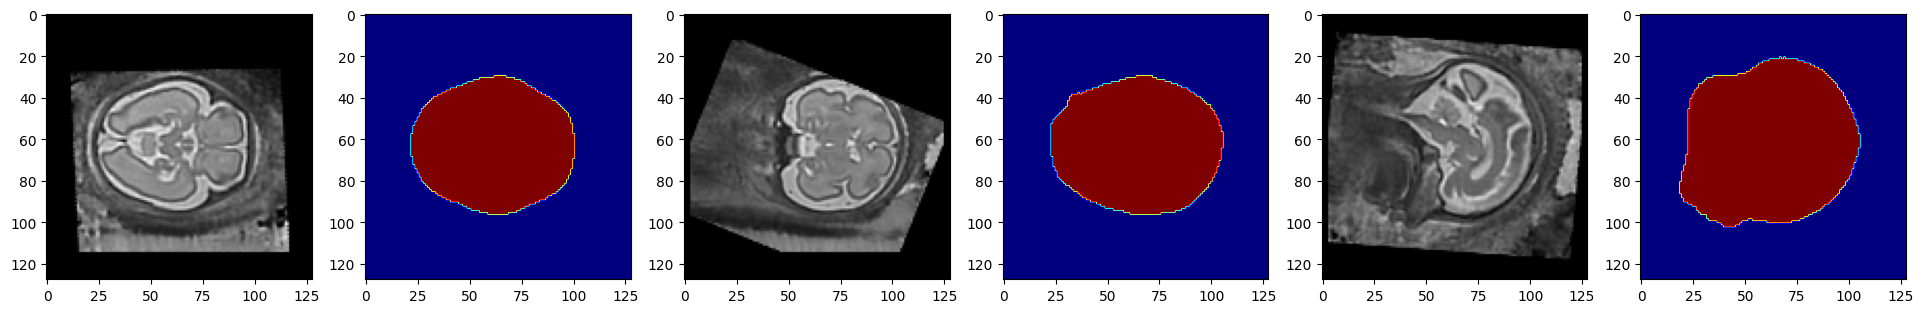

5 hist-136-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


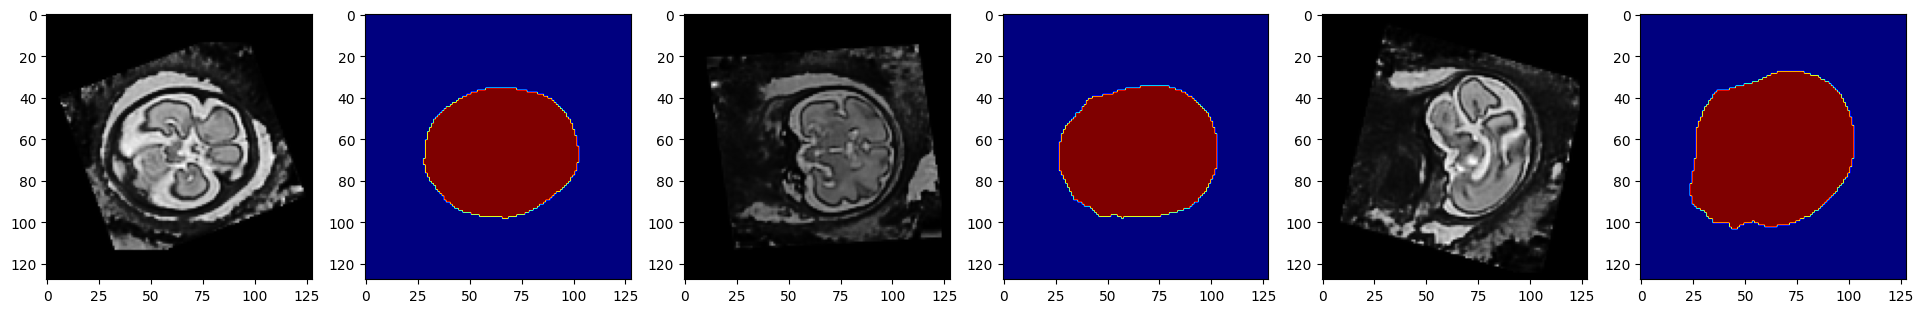

6 hist-214-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


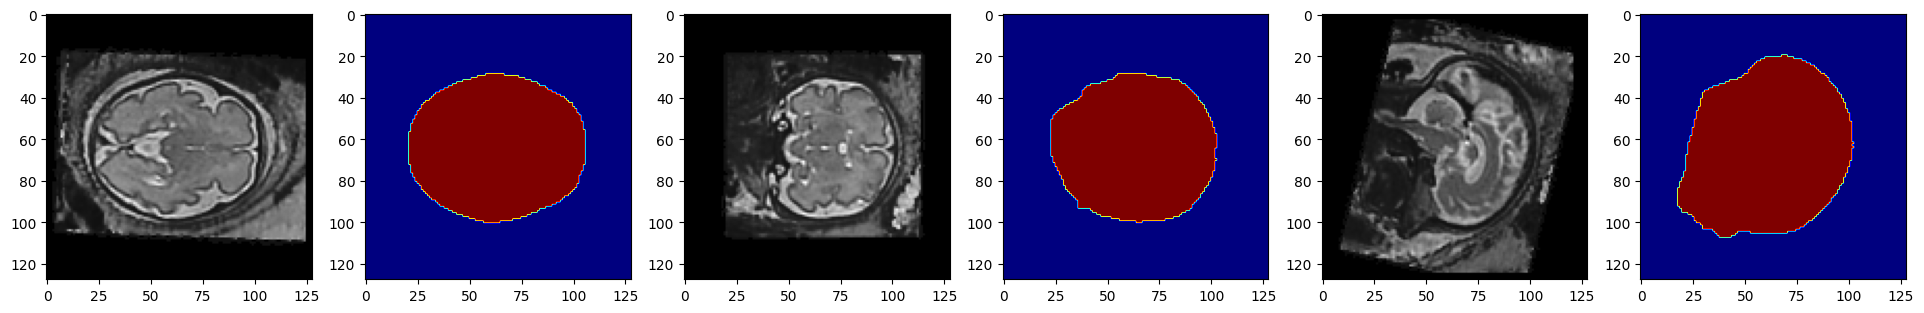

7 hist-236-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


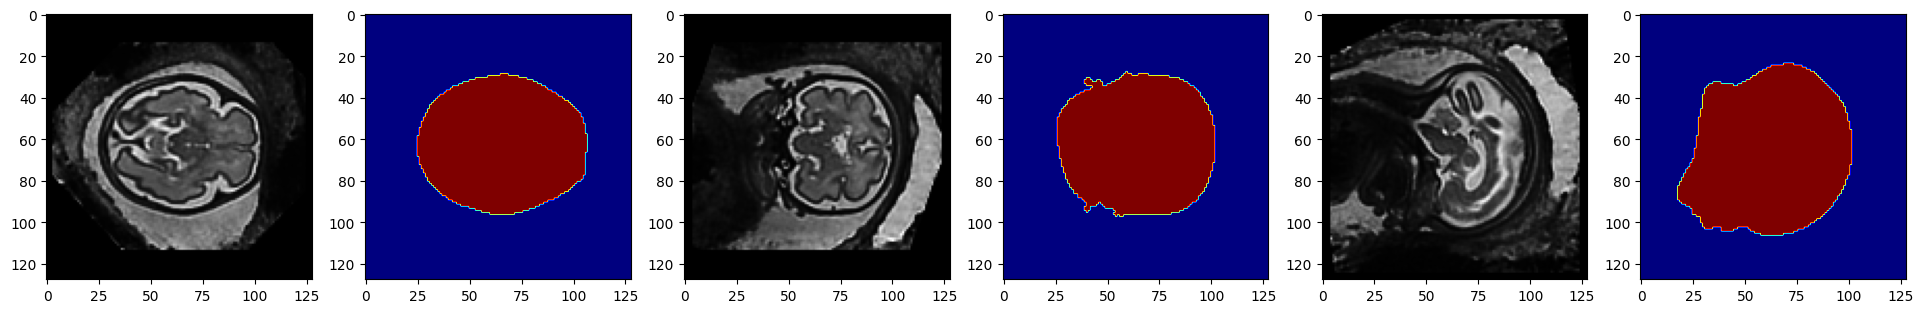

8 hist-253-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


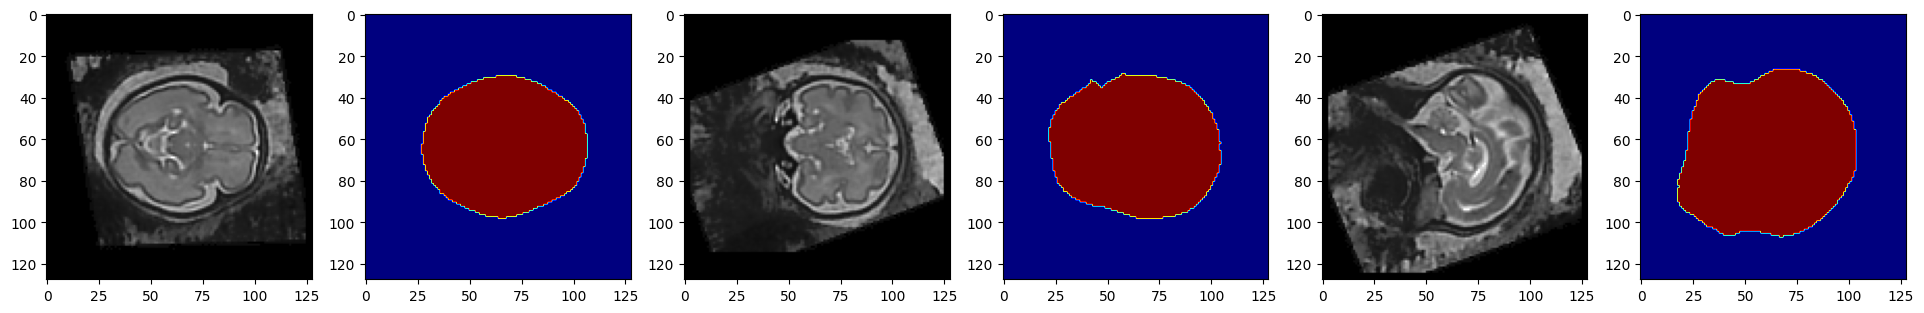

9 hist-275-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


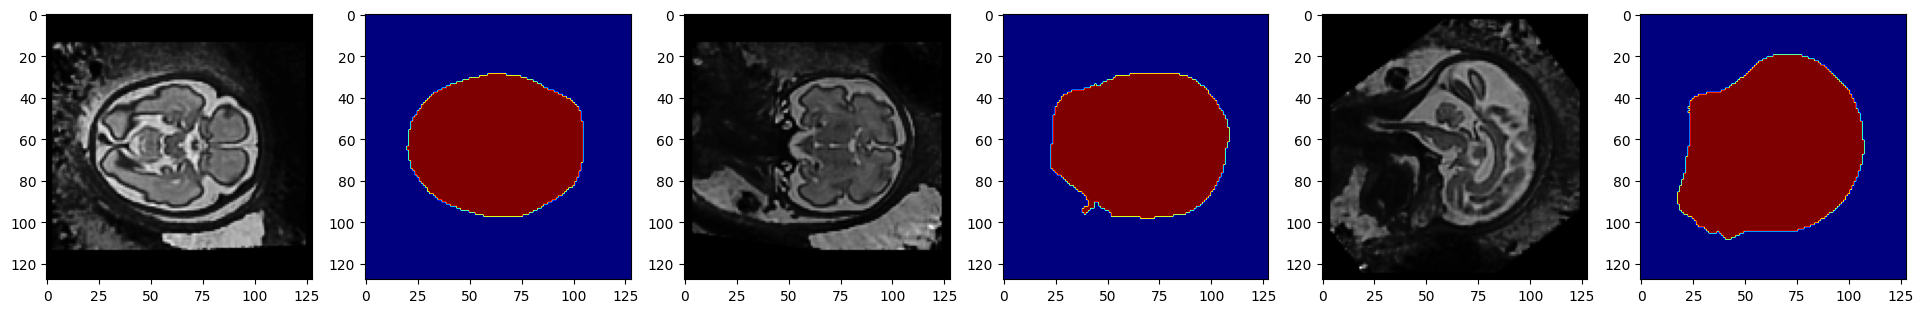

10 hist-292-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


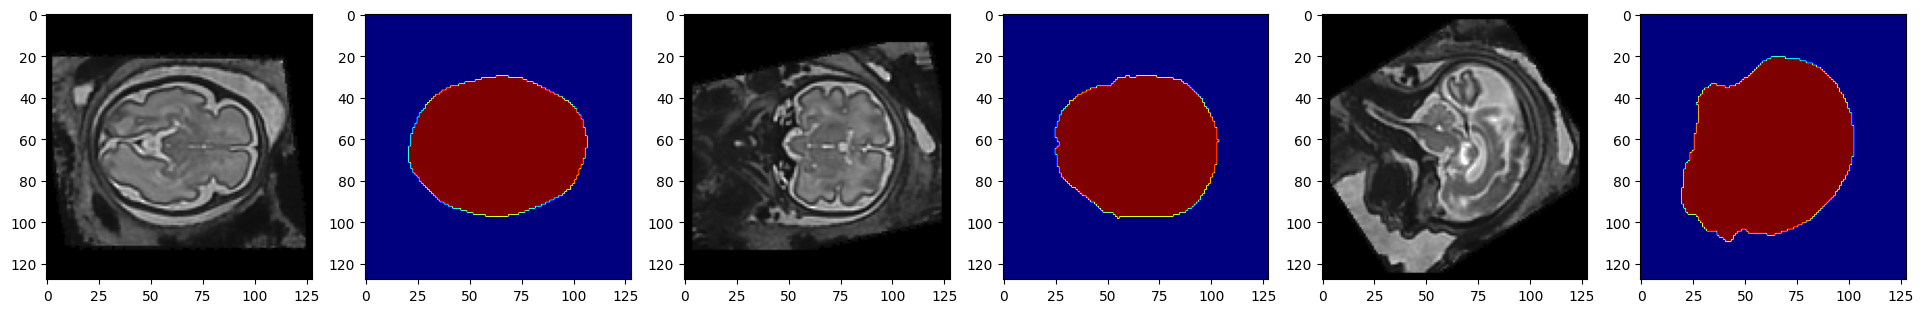

11 hist-355-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


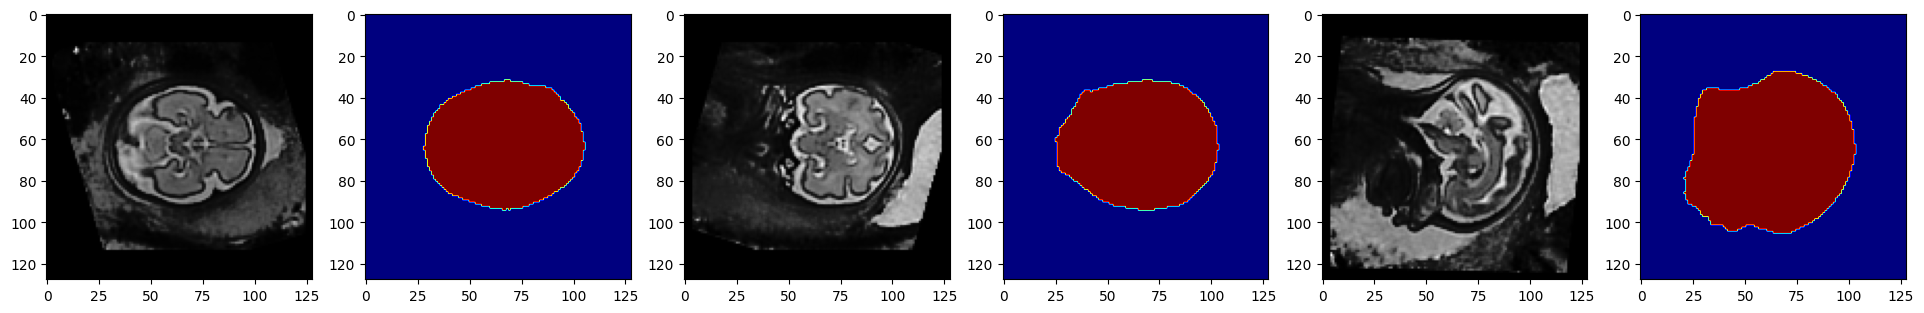

In [ ]:

s=round(img_dim/2)

for x in range(len(val_files)):

  case_num = x
  img_name = val_files[case_num]["label"]
  label_name = val_files[case_num]["label"]
  case_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
  case_in=val_ds[case_num]
  img = case_in["image"]
  label = case_in["label"]
  img_shape = img.shape
  label_shape = label.shape

  print(x, case_name, img_shape, label_shape)
  plt.figure("image", (24, 4))
  plt.subplot(1, 6, 1)
  plt.imshow(img[0, :, :, s], cmap="gray")
  plt.subplot(1, 6, 2)
  plt.imshow(label[0, :, :, s], cmap="jet")
  plt.subplot(1, 6, 3)
  plt.imshow(img[0, :, s, :], cmap="gray")
  plt.subplot(1, 6, 4)
  plt.imshow(label[0, :, s, :], cmap="jet")
  plt.subplot(1, 6, 5)
  plt.imshow(img[0, s, :, :], cmap="gray")
  plt.subplot(1, 6, 6)
  plt.imshow(label[0, s, :, :], cmap="jet")
  plt.show()


In [ ]:
# define the network using MONAI
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = SegResNet(spatial_dims=3,
                  init_filters=32,  # Change from 8 to 32 to match the UNet's initial number of channels
                  in_channels=1,
                  out_channels=class_num,  # Match the number of output channels
                  dropout_prob=0.5,  # Use the same dropout probability
                  norm='INSTANCE',  # Use the same normalization method
                  num_groups=32,  # Adjust the number of groups to match the UNet's channels
                  use_conv_final=True,  # Use a convolutional layer as the final layer
                  blocks_down=(1, 2, 2, 4),  # Match the number of down blocks
                  blocks_up=(1, 1, 1),  # Match the number of up blocks
                  upsample_mode='nontrainable').to(device)  # Use the same upsampling mode



loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [ ]:
def validation(epoch_iterator_val):
    model.eval()
    dice_vals = list()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (img_dim, img_dim, img_dim), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            dice = dice_metric.aggregate().item()
            dice_vals.append(dice)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps) (dice=%2.5f)" % (global_step, 10.0, dice)
            )
        dice_metric.reset()
    mean_dice_val = np.mean(dice_vals)
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best,epochs_without_improvement):
    model.train()
    epoch_loss = 0
    step = 0
    total_training_time = 0
    patience = 10
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    # Initialize variables for early stopping
    start_time = time.time()  # Record the start time
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        # Check if early stopping condition is met
        if epochs_without_improvement >= patience:
          print("Early stopping: Model has not improved for {} epochs.".format(patience))
          epoch_iterator.close()
          epoch_iterator_val.close()
          break

        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            #CHANGE PER MODEL
            epoch_loss_values_segresnet_good_aug.append(epoch_loss)
            #CHANGE PER MODEL
            metric_values_segresnet_good_aug.append(dice_val)

            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                epochs_without_improvement = 0 # Reset patience counter
                print("Patience Counter has Been Reset")
                #CHANGE PER MODEL
                torch.save(
                    model.state_dict(), os.path.join(root_dir, (roi_type+"segresnet_good_aug_best_metric_model.pth"))
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
                print("Epochs Without Improvement:{}".format(epochs_without_improvement))

            else:
              epochs_without_improvement += 1
              #CHANGE PER MODEL
              torch.save(model.state_dict(), os.path.join(root_dir, (roi_type+"segresnet_good_aug_latest_metric_model.pth")))
              print("Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val))
              print("+1 Added to Patience Counter")
              print("Epochs Without Improvement:{}".format(epochs_without_improvement))



        global_step += 1

    # Training loop has completed, calculate the total training time
    end_time = time.time()
    epoch_iterator.close()

    total_training_time += end_time - start_time
    total_training_time_minutes = total_training_time / 60
    print(f"\nTotal Training Time: {total_training_time_minutes:.2f} minutes")
    print(f"Global step: {global_step}, Eval num: {eval_num}, Max iterations: {max_iterations}")
    return global_step, dice_val_best, global_step_best, epochs_without_improvement





In [ ]:
max_iterations = 30000
eval_num = 200
post_label = AsDiscrete(to_onehot=class_num)
post_pred = AsDiscrete(argmax=True, to_onehot=class_num)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epochs_without_improvement = 0
epoch_loss_values_segresnet_good_aug = []
metric_values_segresnet_good_aug = []

In [ ]:
# run training

while global_step < max_iterations:
    global_step, dice_val_best, global_step_best,epochs_without_improvement = train(
        global_step, train_loader, dice_val_best, global_step_best,epochs_without_improvement
    )

Training (81 / 30000 Steps) (loss=0.64136): 100%|██████████| 82/82 [02:52<00:00,  2.10s/it]



Total Training Time: 2.87 minutes
Global step: 82, Eval num: 200, Max iterations: 30000


Training (163 / 30000 Steps) (loss=0.62668): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 164, Eval num: 200, Max iterations: 30000


Training (200 / 30000 Steps) (loss=0.50504):  45%|████▌     | 37/82 [01:07<02:32,  3.39s/it]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.8843762874603271 Current Avg. Dice: 0.8843762874603271
Epochs Without Improvement:0


Training (245 / 30000 Steps) (loss=0.48746): 100%|██████████| 82/82 [02:20<00:00,  1.71s/it]



Total Training Time: 2.33 minutes
Global step: 246, Eval num: 200, Max iterations: 30000


Training (327 / 30000 Steps) (loss=0.54388): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 328, Eval num: 200, Max iterations: 30000


Validate (328 / 10 Steps) (dice=0.91852): 100%|██████████| 12/12 [00:05<00:00,  2.11it/s]


Patience Counter has Been Reset


Training (400 / 30000 Steps) (loss=0.54348):  89%|████████▉ | 73/82 [02:06<00:30,  3.40s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9100886632998785 Current Avg. Dice: 0.9100886632998785
Epochs Without Improvement:0


Training (409 / 30000 Steps) (loss=0.39935): 100%|██████████| 82/82 [02:20<00:00,  1.71s/it]



Total Training Time: 2.34 minutes
Global step: 410, Eval num: 200, Max iterations: 30000


Training (491 / 30000 Steps) (loss=0.35659): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.25 minutes
Global step: 492, Eval num: 200, Max iterations: 30000


Training (573 / 30000 Steps) (loss=0.38612): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 574, Eval num: 200, Max iterations: 30000


Training (600 / 30000 Steps) (loss=0.33827):  33%|███▎      | 27/82 [00:50<03:06,  3.39s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9100886632998785 Current Avg. Dice: 0.8840789198875427
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (655 / 30000 Steps) (loss=0.29877): 100%|██████████| 82/82 [02:19<00:00,  1.70s/it]



Total Training Time: 2.33 minutes
Global step: 656, Eval num: 200, Max iterations: 30000


Training (737 / 30000 Steps) (loss=0.29983): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 738, Eval num: 200, Max iterations: 30000


Validate (738 / 10 Steps) (dice=0.94065): 100%|██████████| 12/12 [00:05<00:00,  2.11it/s]


Patience Counter has Been Reset


Training (800 / 30000 Steps) (loss=0.26925):  77%|███████▋  | 63/82 [01:49<01:04,  3.39s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9296392500400543 Current Avg. Dice: 0.9296392500400543
Epochs Without Improvement:0


Training (819 / 30000 Steps) (loss=0.25791): 100%|██████████| 82/82 [02:20<00:00,  1.71s/it]



Total Training Time: 2.34 minutes
Global step: 820, Eval num: 200, Max iterations: 30000


Training (901 / 30000 Steps) (loss=0.27433): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 902, Eval num: 200, Max iterations: 30000


Training (983 / 30000 Steps) (loss=0.25152): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 984, Eval num: 200, Max iterations: 30000


Validate (984 / 10 Steps) (dice=0.94255): 100%|██████████| 12/12 [00:05<00:00,  2.03it/s]


Patience Counter has Been Reset


Training (1000 / 30000 Steps) (loss=0.18498):  21%|██        | 17/82 [00:34<03:45,  3.48s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9389261106650034 Current Avg. Dice: 0.9389261106650034
Epochs Without Improvement:0


Training (1065 / 30000 Steps) (loss=0.16979): 100%|██████████| 82/82 [02:19<00:00,  1.71s/it]



Total Training Time: 2.33 minutes
Global step: 1066, Eval num: 200, Max iterations: 30000


Training (1147 / 30000 Steps) (loss=0.32525): 100%|██████████| 82/82 [02:14<00:00,  1.65s/it]



Total Training Time: 2.25 minutes
Global step: 1148, Eval num: 200, Max iterations: 30000


Training (1200 / 30000 Steps) (loss=0.18511):  65%|██████▍   | 53/82 [01:33<01:38,  3.41s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9389261106650034 Current Avg. Dice: 0.9332332462072372
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (1229 / 30000 Steps) (loss=0.20726): 100%|██████████| 82/82 [02:19<00:00,  1.71s/it]



Total Training Time: 2.33 minutes
Global step: 1230, Eval num: 200, Max iterations: 30000


Training (1311 / 30000 Steps) (loss=0.13951): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 1312, Eval num: 200, Max iterations: 30000


Training (1393 / 30000 Steps) (loss=0.26029): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 1394, Eval num: 200, Max iterations: 30000


Training (1400 / 30000 Steps) (loss=0.35426):   9%|▊         | 7/82 [00:18<04:33,  3.64s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9389261106650034 Current Avg. Dice: 0.9382572869459788
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (1475 / 30000 Steps) (loss=0.22978): 100%|██████████| 82/82 [02:20<00:00,  1.71s/it]



Total Training Time: 2.33 minutes
Global step: 1476, Eval num: 200, Max iterations: 30000


Training (1557 / 30000 Steps) (loss=0.17845): 100%|██████████| 82/82 [02:14<00:00,  1.65s/it]



Total Training Time: 2.25 minutes
Global step: 1558, Eval num: 200, Max iterations: 30000


Training (1600 / 30000 Steps) (loss=0.11353):  52%|█████▏    | 43/82 [01:16<02:10,  3.34s/it]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.9503061572710673 Current Avg. Dice: 0.9503061572710673
Epochs Without Improvement:0


Training (1639 / 30000 Steps) (loss=0.23187): 100%|██████████| 82/82 [02:19<00:00,  1.70s/it]



Total Training Time: 2.32 minutes
Global step: 1640, Eval num: 200, Max iterations: 30000


Training (1721 / 30000 Steps) (loss=0.11810): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 1722, Eval num: 200, Max iterations: 30000


Validate (1722 / 10 Steps) (dice=0.96328): 100%|██████████| 12/12 [00:05<00:00,  2.18it/s]


Patience Counter has Been Reset


Training (1800 / 30000 Steps) (loss=0.12248):  96%|█████████▋| 79/82 [02:14<00:10,  3.34s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9565223207076391 Current Avg. Dice: 0.9565223207076391
Epochs Without Improvement:0


Training (1803 / 30000 Steps) (loss=0.11356): 100%|██████████| 82/82 [02:19<00:00,  1.70s/it]



Total Training Time: 2.33 minutes
Global step: 1804, Eval num: 200, Max iterations: 30000


Training (1885 / 30000 Steps) (loss=0.09576): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.25 minutes
Global step: 1886, Eval num: 200, Max iterations: 30000


Training (1967 / 30000 Steps) (loss=0.11593): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 1968, Eval num: 200, Max iterations: 30000


Training (2000 / 30000 Steps) (loss=0.28267):  40%|████      | 33/82 [01:00<02:50,  3.48s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9565223207076391 Current Avg. Dice: 0.9394170244534811
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (2049 / 30000 Steps) (loss=0.12993): 100%|██████████| 82/82 [02:20<00:00,  1.71s/it]



Total Training Time: 2.34 minutes
Global step: 2050, Eval num: 200, Max iterations: 30000


Training (2131 / 30000 Steps) (loss=0.20470): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.25 minutes
Global step: 2132, Eval num: 200, Max iterations: 30000


Validate (2132 / 10 Steps) (dice=0.96944): 100%|██████████| 12/12 [00:05<00:00,  2.08it/s]


Patience Counter has Been Reset


Training (2200 / 30000 Steps) (loss=0.20096):  84%|████████▍ | 69/82 [01:59<00:44,  3.43s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9631033192078272 Current Avg. Dice: 0.9631033192078272
Epochs Without Improvement:0


Training (2213 / 30000 Steps) (loss=0.10143): 100%|██████████| 82/82 [02:19<00:00,  1.71s/it]



Total Training Time: 2.33 minutes
Global step: 2214, Eval num: 200, Max iterations: 30000


Training (2295 / 30000 Steps) (loss=0.10527): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 2296, Eval num: 200, Max iterations: 30000


Training (2377 / 30000 Steps) (loss=0.10124): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.25 minutes
Global step: 2378, Eval num: 200, Max iterations: 30000


Validate (2378 / 10 Steps) (dice=0.97436): 100%|██████████| 12/12 [00:05<00:00,  2.08it/s]


Patience Counter has Been Reset


Training (2400 / 30000 Steps) (loss=0.13177):  28%|██▊       | 23/82 [00:43<03:21,  3.42s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9703830728928248 Current Avg. Dice: 0.9703830728928248
Epochs Without Improvement:0


Training (2459 / 30000 Steps) (loss=0.07394): 100%|██████████| 82/82 [02:19<00:00,  1.70s/it]



Total Training Time: 2.32 minutes
Global step: 2460, Eval num: 200, Max iterations: 30000


Training (2541 / 30000 Steps) (loss=0.06056): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.25 minutes
Global step: 2542, Eval num: 200, Max iterations: 30000


Validate (2542 / 10 Steps) (dice=0.97880): 100%|██████████| 12/12 [00:05<00:00,  2.05it/s]


Patience Counter has Been Reset


Training (2600 / 30000 Steps) (loss=0.10651):  72%|███████▏  | 59/82 [01:42<01:19,  3.44s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9769663910071055 Current Avg. Dice: 0.9769663910071055
Epochs Without Improvement:0


Training (2623 / 30000 Steps) (loss=0.07920): 100%|██████████| 82/82 [02:20<00:00,  1.71s/it]



Total Training Time: 2.33 minutes
Global step: 2624, Eval num: 200, Max iterations: 30000


Training (2705 / 30000 Steps) (loss=0.07922): 100%|██████████| 82/82 [02:14<00:00,  1.65s/it]



Total Training Time: 2.25 minutes
Global step: 2706, Eval num: 200, Max iterations: 30000


Training (2787 / 30000 Steps) (loss=0.07404): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 2788, Eval num: 200, Max iterations: 30000


Training (2800 / 30000 Steps) (loss=0.08762):  16%|█▌        | 13/82 [00:28<03:58,  3.46s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9769663910071055 Current Avg. Dice: 0.9749024510383606
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (2869 / 30000 Steps) (loss=0.06884): 100%|██████████| 82/82 [02:20<00:00,  1.71s/it]



Total Training Time: 2.34 minutes
Global step: 2870, Eval num: 200, Max iterations: 30000


Training (2951 / 30000 Steps) (loss=0.05534): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 2952, Eval num: 200, Max iterations: 30000


Training (3000 / 30000 Steps) (loss=0.07049):  60%|█████▉    | 49/82 [01:26<01:51,  3.38s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9769663910071055 Current Avg. Dice: 0.9476118385791779
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (3033 / 30000 Steps) (loss=0.09293): 100%|██████████| 82/82 [02:19<00:00,  1.70s/it]



Total Training Time: 2.33 minutes
Global step: 3034, Eval num: 200, Max iterations: 30000


Training (3115 / 30000 Steps) (loss=0.08322): 100%|██████████| 82/82 [02:15<00:00,  1.65s/it]



Total Training Time: 2.25 minutes
Global step: 3116, Eval num: 200, Max iterations: 30000


Training (3197 / 30000 Steps) (loss=0.04802): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 3198, Eval num: 200, Max iterations: 30000


Training (3200 / 30000 Steps) (loss=0.06996):   4%|▎         | 3/82 [00:11<05:56,  4.52s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9769663910071055 Current Avg. Dice: 0.9763712833325068
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (3279 / 30000 Steps) (loss=0.11610): 100%|██████████| 82/82 [02:19<00:00,  1.70s/it]



Total Training Time: 2.32 minutes
Global step: 3280, Eval num: 200, Max iterations: 30000


Training (3361 / 30000 Steps) (loss=0.06096): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 3362, Eval num: 200, Max iterations: 30000


Validate (3362 / 10 Steps) (dice=0.98311): 100%|██████████| 12/12 [00:05<00:00,  2.07it/s]


Patience Counter has Been Reset


Training (3400 / 30000 Steps) (loss=0.14115):  48%|████▊     | 39/82 [01:10<02:27,  3.43s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9810565660397211 Current Avg. Dice: 0.9810565660397211
Epochs Without Improvement:0


Training (3443 / 30000 Steps) (loss=0.03857): 100%|██████████| 82/82 [02:20<00:00,  1.71s/it]



Total Training Time: 2.34 minutes
Global step: 3444, Eval num: 200, Max iterations: 30000


Training (3525 / 30000 Steps) (loss=0.05261): 100%|██████████| 82/82 [02:15<00:00,  1.65s/it]



Total Training Time: 2.25 minutes
Global step: 3526, Eval num: 200, Max iterations: 30000


Validate (3526 / 10 Steps) (dice=0.98491): 100%|██████████| 12/12 [00:05<00:00,  2.17it/s]


Patience Counter has Been Reset


Training (3600 / 30000 Steps) (loss=0.04147):  91%|█████████▏| 75/82 [02:08<00:23,  3.35s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9823251515626907 Current Avg. Dice: 0.9823251515626907
Epochs Without Improvement:0


Training (3607 / 30000 Steps) (loss=0.04044): 100%|██████████| 82/82 [02:20<00:00,  1.71s/it]



Total Training Time: 2.33 minutes
Global step: 3608, Eval num: 200, Max iterations: 30000


Training (3689 / 30000 Steps) (loss=0.04257): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 3690, Eval num: 200, Max iterations: 30000


Training (3771 / 30000 Steps) (loss=0.08291): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 3772, Eval num: 200, Max iterations: 30000


Validate (3772 / 10 Steps) (dice=0.98525): 100%|██████████| 12/12 [00:05<00:00,  2.02it/s]


Patience Counter has Been Reset


Training (3800 / 30000 Steps) (loss=0.07427):  35%|███▌      | 29/82 [00:54<03:04,  3.48s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9825024058421453 Current Avg. Dice: 0.9825024058421453
Epochs Without Improvement:0


Training (3853 / 30000 Steps) (loss=0.03887): 100%|██████████| 82/82 [02:20<00:00,  1.71s/it]



Total Training Time: 2.34 minutes
Global step: 3854, Eval num: 200, Max iterations: 30000


Training (3935 / 30000 Steps) (loss=0.04772): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.25 minutes
Global step: 3936, Eval num: 200, Max iterations: 30000


Validate (3936 / 10 Steps) (dice=0.98444): 100%|██████████| 12/12 [00:05<00:00,  2.14it/s]


Patience Counter has Been Reset


Training (4000 / 30000 Steps) (loss=0.05133):  79%|███████▉  | 65/82 [01:52<00:57,  3.37s/it]

Model Was Saved ! Current Best Avg. Dice: 0.982632651925087 Current Avg. Dice: 0.982632651925087
Epochs Without Improvement:0


Training (4017 / 30000 Steps) (loss=0.04085): 100%|██████████| 82/82 [02:19<00:00,  1.71s/it]



Total Training Time: 2.33 minutes
Global step: 4018, Eval num: 200, Max iterations: 30000


Training (4099 / 30000 Steps) (loss=0.06309): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 4100, Eval num: 200, Max iterations: 30000


Training (4181 / 30000 Steps) (loss=0.08257): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 4182, Eval num: 200, Max iterations: 30000


Training (4200 / 30000 Steps) (loss=0.04067):  23%|██▎       | 19/82 [00:37<03:33,  3.38s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.982632651925087 Current Avg. Dice: 0.9786136945088705
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (4263 / 30000 Steps) (loss=0.03377): 100%|██████████| 82/82 [02:20<00:00,  1.71s/it]



Total Training Time: 2.33 minutes
Global step: 4264, Eval num: 200, Max iterations: 30000


Training (4345 / 30000 Steps) (loss=0.06608): 100%|██████████| 82/82 [02:15<00:00,  1.65s/it]



Total Training Time: 2.26 minutes
Global step: 4346, Eval num: 200, Max iterations: 30000


Validate (4346 / 10 Steps) (dice=0.98658): 100%|██████████| 12/12 [00:05<00:00,  2.17it/s]


Patience Counter has Been Reset


Training (4400 / 30000 Steps) (loss=0.03043):  67%|██████▋   | 55/82 [01:36<01:30,  3.35s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9838488548994064 Current Avg. Dice: 0.9838488548994064
Epochs Without Improvement:0


Training (4427 / 30000 Steps) (loss=0.07466): 100%|██████████| 82/82 [02:19<00:00,  1.71s/it]



Total Training Time: 2.33 minutes
Global step: 4428, Eval num: 200, Max iterations: 30000


Training (4509 / 30000 Steps) (loss=0.04059): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 4510, Eval num: 200, Max iterations: 30000


Training (4591 / 30000 Steps) (loss=0.03614): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 4592, Eval num: 200, Max iterations: 30000


Validate (4592 / 10 Steps) (dice=0.98643): 100%|██████████| 12/12 [00:05<00:00,  2.04it/s]


Patience Counter has Been Reset


Training (4600 / 30000 Steps) (loss=0.02842):  11%|█         | 9/82 [00:21<04:18,  3.54s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9845481564601263 Current Avg. Dice: 0.9845481564601263
Epochs Without Improvement:0


Training (4673 / 30000 Steps) (loss=0.03026): 100%|██████████| 82/82 [02:20<00:00,  1.71s/it]



Total Training Time: 2.34 minutes
Global step: 4674, Eval num: 200, Max iterations: 30000


Training (4755 / 30000 Steps) (loss=0.04461): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 4756, Eval num: 200, Max iterations: 30000


Training (4800 / 30000 Steps) (loss=0.04045):  55%|█████▍    | 45/82 [01:20<02:07,  3.44s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9845481564601263 Current Avg. Dice: 0.9819867213567098
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (4837 / 30000 Steps) (loss=0.04454): 100%|██████████| 82/82 [02:20<00:00,  1.71s/it]



Total Training Time: 2.34 minutes
Global step: 4838, Eval num: 200, Max iterations: 30000


Training (4919 / 30000 Steps) (loss=0.04720): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 4920, Eval num: 200, Max iterations: 30000


Training (5000 / 30000 Steps) (loss=0.04176):  99%|█████████▉| 81/82 [02:18<00:03,  3.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9845481564601263 Current Avg. Dice: 0.9835669199625651
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (5001 / 30000 Steps) (loss=0.02972): 100%|██████████| 82/82 [02:20<00:00,  1.71s/it]



Total Training Time: 2.34 minutes
Global step: 5002, Eval num: 200, Max iterations: 30000


Training (5083 / 30000 Steps) (loss=0.02949): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 5084, Eval num: 200, Max iterations: 30000


Training (5165 / 30000 Steps) (loss=0.03031): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 5166, Eval num: 200, Max iterations: 30000


Training (5200 / 30000 Steps) (loss=0.02871):  43%|████▎     | 35/82 [01:03<02:38,  3.36s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9845481564601263 Current Avg. Dice: 0.9697710126638412
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (5247 / 30000 Steps) (loss=0.02239): 100%|██████████| 82/82 [02:20<00:00,  1.71s/it]



Total Training Time: 2.34 minutes
Global step: 5248, Eval num: 200, Max iterations: 30000


Training (5329 / 30000 Steps) (loss=0.03670): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 5330, Eval num: 200, Max iterations: 30000


Training (5400 / 30000 Steps) (loss=0.02556):  87%|████████▋ | 71/82 [02:02<00:37,  3.39s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9845481564601263 Current Avg. Dice: 0.9844264139731725
+1 Added to Patience Counter
Epochs Without Improvement:4


Training (5411 / 30000 Steps) (loss=0.02371): 100%|██████████| 82/82 [02:20<00:00,  1.71s/it]



Total Training Time: 2.33 minutes
Global step: 5412, Eval num: 200, Max iterations: 30000


Training (5493 / 30000 Steps) (loss=0.03761): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 5494, Eval num: 200, Max iterations: 30000


Training (5575 / 30000 Steps) (loss=0.02826): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.25 minutes
Global step: 5576, Eval num: 200, Max iterations: 30000


Training (5600 / 30000 Steps) (loss=0.04048):  30%|███       | 25/82 [00:47<03:18,  3.48s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9845481564601263 Current Avg. Dice: 0.9833085685968399
+1 Added to Patience Counter
Epochs Without Improvement:5


Training (5657 / 30000 Steps) (loss=0.04922): 100%|██████████| 82/82 [02:20<00:00,  1.71s/it]



Total Training Time: 2.34 minutes
Global step: 5658, Eval num: 200, Max iterations: 30000


Training (5739 / 30000 Steps) (loss=0.03348): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.25 minutes
Global step: 5740, Eval num: 200, Max iterations: 30000


Training (5800 / 30000 Steps) (loss=0.02682):  74%|███████▍  | 61/82 [01:46<01:13,  3.48s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9845481564601263 Current Avg. Dice: 0.9842682679494222
+1 Added to Patience Counter
Epochs Without Improvement:6


Training (5821 / 30000 Steps) (loss=0.02571): 100%|██████████| 82/82 [02:20<00:00,  1.71s/it]



Total Training Time: 2.34 minutes
Global step: 5822, Eval num: 200, Max iterations: 30000


Training (5903 / 30000 Steps) (loss=0.03661): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.25 minutes
Global step: 5904, Eval num: 200, Max iterations: 30000


Training (5985 / 30000 Steps) (loss=0.02714): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 5986, Eval num: 200, Max iterations: 30000


Validate (5986 / 10 Steps) (dice=0.98773): 100%|██████████| 12/12 [00:05<00:00,  2.11it/s]


Patience Counter has Been Reset


Training (6000 / 30000 Steps) (loss=0.03208):  18%|█▊        | 15/82 [00:31<03:47,  3.40s/it]

Model Was Saved ! Current Best Avg. Dice: 0.984904279311498 Current Avg. Dice: 0.984904279311498
Epochs Without Improvement:0


Training (6067 / 30000 Steps) (loss=0.01879): 100%|██████████| 82/82 [02:19<00:00,  1.70s/it]



Total Training Time: 2.33 minutes
Global step: 6068, Eval num: 200, Max iterations: 30000


Training (6149 / 30000 Steps) (loss=0.02879): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 6150, Eval num: 200, Max iterations: 30000


Training (6200 / 30000 Steps) (loss=0.02005):  62%|██████▏   | 51/82 [01:30<01:49,  3.52s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.984904279311498 Current Avg. Dice: 0.9848751425743103
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (6231 / 30000 Steps) (loss=0.02680): 100%|██████████| 82/82 [02:20<00:00,  1.71s/it]



Total Training Time: 2.34 minutes
Global step: 6232, Eval num: 200, Max iterations: 30000


Training (6313 / 30000 Steps) (loss=0.02468): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 6314, Eval num: 200, Max iterations: 30000


Training (6395 / 30000 Steps) (loss=0.03519): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 6396, Eval num: 200, Max iterations: 30000


Training (6400 / 30000 Steps) (loss=0.04514):   6%|▌         | 5/82 [00:15<04:58,  3.87s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.984904279311498 Current Avg. Dice: 0.9839894423882166
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (6477 / 30000 Steps) (loss=0.04097): 100%|██████████| 82/82 [02:20<00:00,  1.71s/it]



Total Training Time: 2.34 minutes
Global step: 6478, Eval num: 200, Max iterations: 30000


Training (6559 / 30000 Steps) (loss=0.03094): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 6560, Eval num: 200, Max iterations: 30000


Training (6600 / 30000 Steps) (loss=0.02155):  50%|█████     | 41/82 [01:13<02:21,  3.46s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.984904279311498 Current Avg. Dice: 0.9837808360656103
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (6641 / 30000 Steps) (loss=0.02160): 100%|██████████| 82/82 [02:20<00:00,  1.71s/it]



Total Training Time: 2.34 minutes
Global step: 6642, Eval num: 200, Max iterations: 30000


Training (6723 / 30000 Steps) (loss=0.04196): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 6724, Eval num: 200, Max iterations: 30000


Training (6800 / 30000 Steps) (loss=0.02352):  94%|█████████▍| 77/82 [02:12<00:17,  3.43s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.984904279311498 Current Avg. Dice: 0.9846966167291006
+1 Added to Patience Counter
Epochs Without Improvement:4


Training (6805 / 30000 Steps) (loss=0.02748): 100%|██████████| 82/82 [02:20<00:00,  1.71s/it]



Total Training Time: 2.34 minutes
Global step: 6806, Eval num: 200, Max iterations: 30000


Training (6887 / 30000 Steps) (loss=0.04267): 100%|██████████| 82/82 [02:14<00:00,  1.63s/it]



Total Training Time: 2.23 minutes
Global step: 6888, Eval num: 200, Max iterations: 30000


Training (6969 / 30000 Steps) (loss=0.01918): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 6970, Eval num: 200, Max iterations: 30000


Validate (6970 / 10 Steps) (dice=0.98767): 100%|██████████| 12/12 [00:05<00:00,  2.04it/s]


Patience Counter has Been Reset


Training (7000 / 30000 Steps) (loss=0.02829):  38%|███▊      | 31/82 [00:57<02:56,  3.47s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9855026205380758 Current Avg. Dice: 0.9855026205380758
Epochs Without Improvement:0


Training (7051 / 30000 Steps) (loss=0.02163): 100%|██████████| 82/82 [02:20<00:00,  1.71s/it]



Total Training Time: 2.33 minutes
Global step: 7052, Eval num: 200, Max iterations: 30000


Training (7133 / 30000 Steps) (loss=0.02840): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 7134, Eval num: 200, Max iterations: 30000


Training (7200 / 30000 Steps) (loss=0.03758):  82%|████████▏ | 67/82 [01:56<00:52,  3.47s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9855026205380758 Current Avg. Dice: 0.9770353188117346
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (7215 / 30000 Steps) (loss=0.02195): 100%|██████████| 82/82 [02:20<00:00,  1.71s/it]



Total Training Time: 2.34 minutes
Global step: 7216, Eval num: 200, Max iterations: 30000


Training (7297 / 30000 Steps) (loss=0.05815): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.25 minutes
Global step: 7298, Eval num: 200, Max iterations: 30000


Training (7379 / 30000 Steps) (loss=0.03336): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 7380, Eval num: 200, Max iterations: 30000


Training (7400 / 30000 Steps) (loss=0.02844):  26%|██▌       | 21/82 [00:40<03:35,  3.53s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9855026205380758 Current Avg. Dice: 0.9833581695954005
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (7461 / 30000 Steps) (loss=0.05361): 100%|██████████| 82/82 [02:19<00:00,  1.71s/it]



Total Training Time: 2.33 minutes
Global step: 7462, Eval num: 200, Max iterations: 30000


Training (7543 / 30000 Steps) (loss=0.02342): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 7544, Eval num: 200, Max iterations: 30000


Training (7600 / 30000 Steps) (loss=0.03035):  70%|██████▉   | 57/82 [01:39<01:23,  3.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9855026205380758 Current Avg. Dice: 0.9840594331423441
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (7625 / 30000 Steps) (loss=0.02322): 100%|██████████| 82/82 [02:20<00:00,  1.71s/it]



Total Training Time: 2.34 minutes
Global step: 7626, Eval num: 200, Max iterations: 30000


Training (7707 / 30000 Steps) (loss=0.02461): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 7708, Eval num: 200, Max iterations: 30000


Training (7789 / 30000 Steps) (loss=0.02846): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 7790, Eval num: 200, Max iterations: 30000


Training (7800 / 30000 Steps) (loss=0.03545):  13%|█▎        | 11/82 [00:24<04:11,  3.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9855026205380758 Current Avg. Dice: 0.9852150330940882
+1 Added to Patience Counter
Epochs Without Improvement:4


Training (7871 / 30000 Steps) (loss=0.03803): 100%|██████████| 82/82 [02:20<00:00,  1.71s/it]



Total Training Time: 2.33 minutes
Global step: 7872, Eval num: 200, Max iterations: 30000


Training (7953 / 30000 Steps) (loss=0.04017): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 7954, Eval num: 200, Max iterations: 30000


Training (8000 / 30000 Steps) (loss=0.02111):  57%|█████▋    | 47/82 [01:23<01:58,  3.39s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9855026205380758 Current Avg. Dice: 0.9849352339903513
+1 Added to Patience Counter
Epochs Without Improvement:5


Training (8035 / 30000 Steps) (loss=0.01808): 100%|██████████| 82/82 [02:20<00:00,  1.71s/it]



Total Training Time: 2.33 minutes
Global step: 8036, Eval num: 200, Max iterations: 30000


Training (8117 / 30000 Steps) (loss=0.02641): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 8118, Eval num: 200, Max iterations: 30000


Training (8199 / 30000 Steps) (loss=0.02460): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 8200, Eval num: 200, Max iterations: 30000


Training (8200 / 30000 Steps) (loss=0.03405):   1%|          | 1/82 [00:09<12:14,  9.07s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9855026205380758 Current Avg. Dice: 0.9853697021802267
+1 Added to Patience Counter
Epochs Without Improvement:6


Training (8281 / 30000 Steps) (loss=0.02291): 100%|██████████| 82/82 [02:20<00:00,  1.71s/it]



Total Training Time: 2.34 minutes
Global step: 8282, Eval num: 200, Max iterations: 30000


Training (8363 / 30000 Steps) (loss=0.03848): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 8364, Eval num: 200, Max iterations: 30000


Validate (8364 / 10 Steps) (dice=0.98811): 100%|██████████| 12/12 [00:05<00:00,  2.02it/s]


Patience Counter has Been Reset


Training (8400 / 30000 Steps) (loss=0.03114):  45%|████▌     | 37/82 [01:07<02:36,  3.47s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9855337589979172 Current Avg. Dice: 0.9855337589979172
Epochs Without Improvement:0


Training (8445 / 30000 Steps) (loss=0.02088): 100%|██████████| 82/82 [02:20<00:00,  1.71s/it]



Total Training Time: 2.34 minutes
Global step: 8446, Eval num: 200, Max iterations: 30000


Training (8527 / 30000 Steps) (loss=0.06582): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 8528, Eval num: 200, Max iterations: 30000


Training (8600 / 30000 Steps) (loss=0.02806):  89%|████████▉ | 73/82 [02:06<00:31,  3.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9855337589979172 Current Avg. Dice: 0.984766274690628
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (8609 / 30000 Steps) (loss=0.05384): 100%|██████████| 82/82 [02:20<00:00,  1.72s/it]



Total Training Time: 2.35 minutes
Global step: 8610, Eval num: 200, Max iterations: 30000


Training (8691 / 30000 Steps) (loss=0.03009): 100%|██████████| 82/82 [02:14<00:00,  1.65s/it]



Total Training Time: 2.25 minutes
Global step: 8692, Eval num: 200, Max iterations: 30000


Training (8773 / 30000 Steps) (loss=0.02737): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 8774, Eval num: 200, Max iterations: 30000


Training (8800 / 30000 Steps) (loss=0.01969):  33%|███▎      | 27/82 [00:50<03:04,  3.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9855337589979172 Current Avg. Dice: 0.9853416134913763
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (8855 / 30000 Steps) (loss=0.02846): 100%|██████████| 82/82 [02:19<00:00,  1.70s/it]



Total Training Time: 2.32 minutes
Global step: 8856, Eval num: 200, Max iterations: 30000


Training (8937 / 30000 Steps) (loss=0.02696): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 8938, Eval num: 200, Max iterations: 30000


Validate (8938 / 10 Steps) (dice=0.98875): 100%|██████████| 12/12 [00:06<00:00,  1.99it/s]


Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.9859882742166519 Current Avg. Dice: 0.9859882742166519
Epochs Without Improvement:0


Training (9019 / 30000 Steps) (loss=0.01484): 100%|██████████| 82/82 [02:20<00:00,  1.71s/it]



Total Training Time: 2.34 minutes
Global step: 9020, Eval num: 200, Max iterations: 30000


Training (9101 / 30000 Steps) (loss=0.02319): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 9102, Eval num: 200, Max iterations: 30000


Training (9183 / 30000 Steps) (loss=0.02105): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 9184, Eval num: 200, Max iterations: 30000


Training (9200 / 30000 Steps) (loss=0.02322):  21%|██        | 17/82 [00:34<03:46,  3.48s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9859882742166519 Current Avg. Dice: 0.9851200729608536
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (9265 / 30000 Steps) (loss=0.02205): 100%|██████████| 82/82 [02:20<00:00,  1.71s/it]



Total Training Time: 2.33 minutes
Global step: 9266, Eval num: 200, Max iterations: 30000


Training (9347 / 30000 Steps) (loss=0.02451): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 9348, Eval num: 200, Max iterations: 30000


Training (9400 / 30000 Steps) (loss=0.03832):  65%|██████▍   | 53/82 [01:33<01:41,  3.51s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9859882742166519 Current Avg. Dice: 0.9858539154132208
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (9429 / 30000 Steps) (loss=0.02011): 100%|██████████| 82/82 [02:20<00:00,  1.71s/it]



Total Training Time: 2.34 minutes
Global step: 9430, Eval num: 200, Max iterations: 30000


Training (9511 / 30000 Steps) (loss=0.03890): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.25 minutes
Global step: 9512, Eval num: 200, Max iterations: 30000


Training (9593 / 30000 Steps) (loss=0.02624): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.25 minutes
Global step: 9594, Eval num: 200, Max iterations: 30000


Training (9600 / 30000 Steps) (loss=0.02609):   9%|▊         | 7/82 [00:18<04:32,  3.64s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9859882742166519 Current Avg. Dice: 0.981847087542216
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (9675 / 30000 Steps) (loss=0.02576): 100%|██████████| 82/82 [02:20<00:00,  1.71s/it]



Total Training Time: 2.33 minutes
Global step: 9676, Eval num: 200, Max iterations: 30000


Training (9757 / 30000 Steps) (loss=0.04149): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 9758, Eval num: 200, Max iterations: 30000


Training (9800 / 30000 Steps) (loss=0.02105):  52%|█████▏    | 43/82 [01:17<02:13,  3.41s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9859882742166519 Current Avg. Dice: 0.984701340397199
+1 Added to Patience Counter
Epochs Without Improvement:4


Training (9839 / 30000 Steps) (loss=0.01729): 100%|██████████| 82/82 [02:20<00:00,  1.71s/it]



Total Training Time: 2.34 minutes
Global step: 9840, Eval num: 200, Max iterations: 30000


Training (9921 / 30000 Steps) (loss=0.01916): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 9922, Eval num: 200, Max iterations: 30000


Validate (9922 / 10 Steps) (dice=0.98874): 100%|██████████| 12/12 [00:05<00:00,  2.12it/s]


Patience Counter has Been Reset


Training (10000 / 30000 Steps) (loss=0.01878):  96%|█████████▋| 79/82 [02:14<00:10,  3.39s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9861145714918772 Current Avg. Dice: 0.9861145714918772
Epochs Without Improvement:0


Training (10003 / 30000 Steps) (loss=0.02340): 100%|██████████| 82/82 [02:19<00:00,  1.71s/it]



Total Training Time: 2.33 minutes
Global step: 10004, Eval num: 200, Max iterations: 30000


Training (10085 / 30000 Steps) (loss=0.01882): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 10086, Eval num: 200, Max iterations: 30000


Training (10167 / 30000 Steps) (loss=0.01726): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.25 minutes
Global step: 10168, Eval num: 200, Max iterations: 30000


Training (10200 / 30000 Steps) (loss=0.03922):  40%|████      | 33/82 [01:01<02:50,  3.49s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9861145714918772 Current Avg. Dice: 0.9856138626734415
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (10249 / 30000 Steps) (loss=0.01866): 100%|██████████| 82/82 [02:20<00:00,  1.71s/it]



Total Training Time: 2.34 minutes
Global step: 10250, Eval num: 200, Max iterations: 30000


Training (10331 / 30000 Steps) (loss=0.02357): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.25 minutes
Global step: 10332, Eval num: 200, Max iterations: 30000


Validate (10332 / 10 Steps) (dice=0.98913): 100%|██████████| 12/12 [00:05<00:00,  2.14it/s]


Patience Counter has Been Reset


Training (10400 / 30000 Steps) (loss=0.03034):  84%|████████▍ | 69/82 [01:58<00:43,  3.37s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9863151659568151 Current Avg. Dice: 0.9863151659568151
Epochs Without Improvement:0


Training (10413 / 30000 Steps) (loss=0.01792): 100%|██████████| 82/82 [02:19<00:00,  1.71s/it]



Total Training Time: 2.33 minutes
Global step: 10414, Eval num: 200, Max iterations: 30000


Training (10495 / 30000 Steps) (loss=0.04749): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.25 minutes
Global step: 10496, Eval num: 200, Max iterations: 30000


Training (10577 / 30000 Steps) (loss=0.01435): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 10578, Eval num: 200, Max iterations: 30000


Training (10600 / 30000 Steps) (loss=0.03791):  28%|██▊       | 23/82 [00:45<03:31,  3.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9863151659568151 Current Avg. Dice: 0.9858776926994324
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (10659 / 30000 Steps) (loss=0.02174): 100%|██████████| 82/82 [02:20<00:00,  1.72s/it]



Total Training Time: 2.35 minutes
Global step: 10660, Eval num: 200, Max iterations: 30000


Training (10741 / 30000 Steps) (loss=0.01585): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 10742, Eval num: 200, Max iterations: 30000


Training (10800 / 30000 Steps) (loss=0.02332):  72%|███████▏  | 59/82 [01:43<01:20,  3.48s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9863151659568151 Current Avg. Dice: 0.9856238961219788
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (10823 / 30000 Steps) (loss=0.02924): 100%|██████████| 82/82 [02:20<00:00,  1.71s/it]



Total Training Time: 2.34 minutes
Global step: 10824, Eval num: 200, Max iterations: 30000


Training (10905 / 30000 Steps) (loss=0.02505): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 10906, Eval num: 200, Max iterations: 30000


Training (10987 / 30000 Steps) (loss=0.02339): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 10988, Eval num: 200, Max iterations: 30000


Training (11000 / 30000 Steps) (loss=0.02569):  16%|█▌        | 13/82 [00:28<03:59,  3.48s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9863151659568151 Current Avg. Dice: 0.986037497719129
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (11069 / 30000 Steps) (loss=0.01682): 100%|██████████| 82/82 [02:20<00:00,  1.71s/it]



Total Training Time: 2.34 minutes
Global step: 11070, Eval num: 200, Max iterations: 30000


Training (11151 / 30000 Steps) (loss=0.02573): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.25 minutes
Global step: 11152, Eval num: 200, Max iterations: 30000


Training (11200 / 30000 Steps) (loss=0.02818):  60%|█████▉    | 49/82 [01:26<01:54,  3.47s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9863151659568151 Current Avg. Dice: 0.9854200134674708
+1 Added to Patience Counter
Epochs Without Improvement:4


Training (11233 / 30000 Steps) (loss=0.01976): 100%|██████████| 82/82 [02:19<00:00,  1.71s/it]



Total Training Time: 2.33 minutes
Global step: 11234, Eval num: 200, Max iterations: 30000


Training (11315 / 30000 Steps) (loss=0.02196): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.25 minutes
Global step: 11316, Eval num: 200, Max iterations: 30000


Training (11397 / 30000 Steps) (loss=0.01811): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.25 minutes
Global step: 11398, Eval num: 200, Max iterations: 30000


Training (11400 / 30000 Steps) (loss=0.01654):   4%|▎         | 3/82 [00:12<06:14,  4.74s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9863151659568151 Current Avg. Dice: 0.9858393768469492
+1 Added to Patience Counter
Epochs Without Improvement:5


Training (11479 / 30000 Steps) (loss=0.02142): 100%|██████████| 82/82 [02:20<00:00,  1.71s/it]



Total Training Time: 2.34 minutes
Global step: 11480, Eval num: 200, Max iterations: 30000


Training (11561 / 30000 Steps) (loss=0.02434): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.25 minutes
Global step: 11562, Eval num: 200, Max iterations: 30000


Training (11600 / 30000 Steps) (loss=0.02457):  48%|████▊     | 39/82 [01:10<02:24,  3.36s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9863151659568151 Current Avg. Dice: 0.9857157170772552
+1 Added to Patience Counter
Epochs Without Improvement:6


Training (11643 / 30000 Steps) (loss=0.02120): 100%|██████████| 82/82 [02:19<00:00,  1.71s/it]



Total Training Time: 2.33 minutes
Global step: 11644, Eval num: 200, Max iterations: 30000


Training (11725 / 30000 Steps) (loss=0.01733): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.25 minutes
Global step: 11726, Eval num: 200, Max iterations: 30000


Training (11800 / 30000 Steps) (loss=0.02158):  91%|█████████▏| 75/82 [02:09<00:24,  3.44s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9863151659568151 Current Avg. Dice: 0.985340341925621
+1 Added to Patience Counter
Epochs Without Improvement:7


Training (11807 / 30000 Steps) (loss=0.04121): 100%|██████████| 82/82 [02:20<00:00,  1.71s/it]



Total Training Time: 2.34 minutes
Global step: 11808, Eval num: 200, Max iterations: 30000


Training (11889 / 30000 Steps) (loss=0.01700): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 11890, Eval num: 200, Max iterations: 30000


Training (11971 / 30000 Steps) (loss=0.03044): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 11972, Eval num: 200, Max iterations: 30000


Training (12000 / 30000 Steps) (loss=0.02173):  35%|███▌      | 29/82 [00:54<03:00,  3.40s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9863151659568151 Current Avg. Dice: 0.985966737071673
+1 Added to Patience Counter
Epochs Without Improvement:8


Training (12053 / 30000 Steps) (loss=0.01823): 100%|██████████| 82/82 [02:20<00:00,  1.71s/it]



Total Training Time: 2.33 minutes
Global step: 12054, Eval num: 200, Max iterations: 30000


Training (12135 / 30000 Steps) (loss=0.02309): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 12136, Eval num: 200, Max iterations: 30000


Training (12200 / 30000 Steps) (loss=0.02699):  79%|███████▉  | 65/82 [01:53<01:00,  3.56s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9863151659568151 Current Avg. Dice: 0.9860440194606781
+1 Added to Patience Counter
Epochs Without Improvement:9


Training (12217 / 30000 Steps) (loss=0.03968): 100%|██████████| 82/82 [02:20<00:00,  1.72s/it]



Total Training Time: 2.34 minutes
Global step: 12218, Eval num: 200, Max iterations: 30000


Training (12299 / 30000 Steps) (loss=0.01948): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.24 minutes
Global step: 12300, Eval num: 200, Max iterations: 30000


Training (12381 / 30000 Steps) (loss=0.01640): 100%|██████████| 82/82 [02:14<00:00,  1.64s/it]



Total Training Time: 2.25 minutes
Global step: 12382, Eval num: 200, Max iterations: 30000


Training (12400 / 30000 Steps) (loss=0.02402):  23%|██▎       | 19/82 [00:38<03:36,  3.44s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9863151659568151 Current Avg. Dice: 0.9854795634746552
+1 Added to Patience Counter
Epochs Without Improvement:10


Training (12401 / 30000 Steps) (loss=0.02270):  23%|██▎       | 19/82 [00:39<02:11,  2.09s/it]


Early stopping: Model has not improved for 10 epochs.

Total Training Time: 0.66 minutes
Global step: 12401, Eval num: 200, Max iterations: 30000


Training (12401 / 30000 Steps) (loss=0.02801):   0%|          | 0/82 [00:02<?, ?it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Custom TB Handler failed, unregistering
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Early stopping: Model has not improved for 10 epochs.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-316754e11bcc>", line 4, in <cell line: 3>
    global_step, dice_val_best, global_step_best,epochs_without_improvement = train(
  File "<ipython-input-10-1eada31b65d6>", line 57, in train
    epoch_iterator_val.close()
UnboundLocalError: local variable 'epoch_iterator_val' referenced before assignment

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 248, in wrapped
    return f(*args, **kwargs)
  File "/usr/loc

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-316754e11bcc>", line 4, in <cell line: 3>
    global_step, dice_val_best, global_step_best,epochs_without_improvement = train(
  File "<ipython-input-10-1eada31b65d6>", line 57, in train
    epoch_iterator_val.close()
UnboundLocalError: local variable 'epoch_iterator_val' referenced before assignment

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 1972, in wrapped
    stb = handler(self,etype,value,tb,tb_offset=tb_offset)
  File "/usr/local/lib/python3.10/dist-packages/dask/base.py", line 79, in _clean_ipython_traceback
    stb = self.InteractiveTB.structured_traceback(
  File "/usr/local/lib/python3.10/dist-packages/IPython/c

In [ ]:
print(dice_val_best)

0.9863151659568151


In [ ]:
#CHANGE PER MODEL
torch.save(model.state_dict(), os.path.join(root_dir, (roi_type+"segresnet_good_aug_best_metric_model.pth")))
#CHANGE PER MODEL
model.load_state_dict(torch.load(os.path.join(root_dir, (roi_type+"segresnet_good_aug_best_metric_model.pth"))))

<All keys matched successfully>

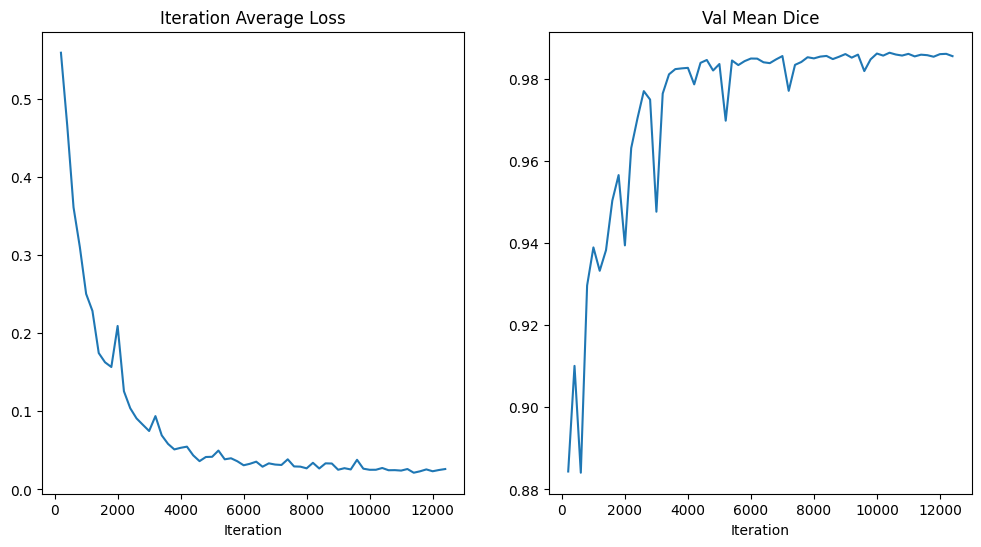

In [ ]:
# plot loss

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
#CHANGE PER MODEL
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values_segresnet_good_aug))]
#CHANGE PER MODEL
y = epoch_loss_values_segresnet_good_aug
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
#CHANGE PER MODEL
x = [eval_num * (i + 1) for i in range(len(metric_values_segresnet_good_aug))]
#CHANGE PER MODEL
y = metric_values_segresnet_good_aug
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

# Save the metric values and epoch loss values to separate files
#CHANGE PER MODEL
np.save(os.path.join(root_dir, (roi_type + "metric_values_segresnet_good_aug.npy")), np.array(metric_values_segresnet_good_aug))
#CHANGE PER MODEL
np.save(os.path.join(root_dir, (roi_type + "epoch_loss_values_segresnet_good_aug.npy")), np.array(epoch_loss_values_segresnet_good_aug))

In [ ]:
torch.save(model.state_dict(), os.path.join(root_dir, (roi_type+"segresnet_good_aug_best_metric_model.pthh")))
model.load_state_dict(torch.load(os.path.join(root_dir, (roi_type+"segresnet_good_aug_best_metric_model.pth"))))

<All keys matched successfully>

In [ ]:
split_JSON_run = "face-training-1-lab-v1.json"


datasets_run = data_dir + split_JSON_run
val_files_run = load_decathlon_datalist(datasets_run, True, "validation")
val_ds_run = CacheDataset(
    data=val_files_run, transform=val_transforms, cache_num=300, cache_rate=1.0, num_workers=4
)
val_loader_run = DataLoader(
    val_ds_run, batch_size=1, shuffle=False, num_workers=4, pin_memory=True
)

Loading dataset: 100%|██████████| 12/12 [00:00<00:00, 29.10it/s]


In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, (roi_type+"segresnet_good_aug_best_metric_model.pth"))), strict=False)
model.eval()

SegResNet(
  (act_mod): ReLU(inplace=True)
  (convInit): Convolution(
    (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  )
  (down_layers): ModuleList(
    (0): Sequential(
      (0): Identity()
      (1): ResBlock(
        (norm1): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (norm2): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (act): ReLU(inplace=True)
        (conv1): Convolution(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
        (conv2): Convolution(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
      )
    )
    (1): Sequential(
      (0): Convolution(
        (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      )
      (1): ResBlock(
        (norm1):

0 261-img.nii.gz
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


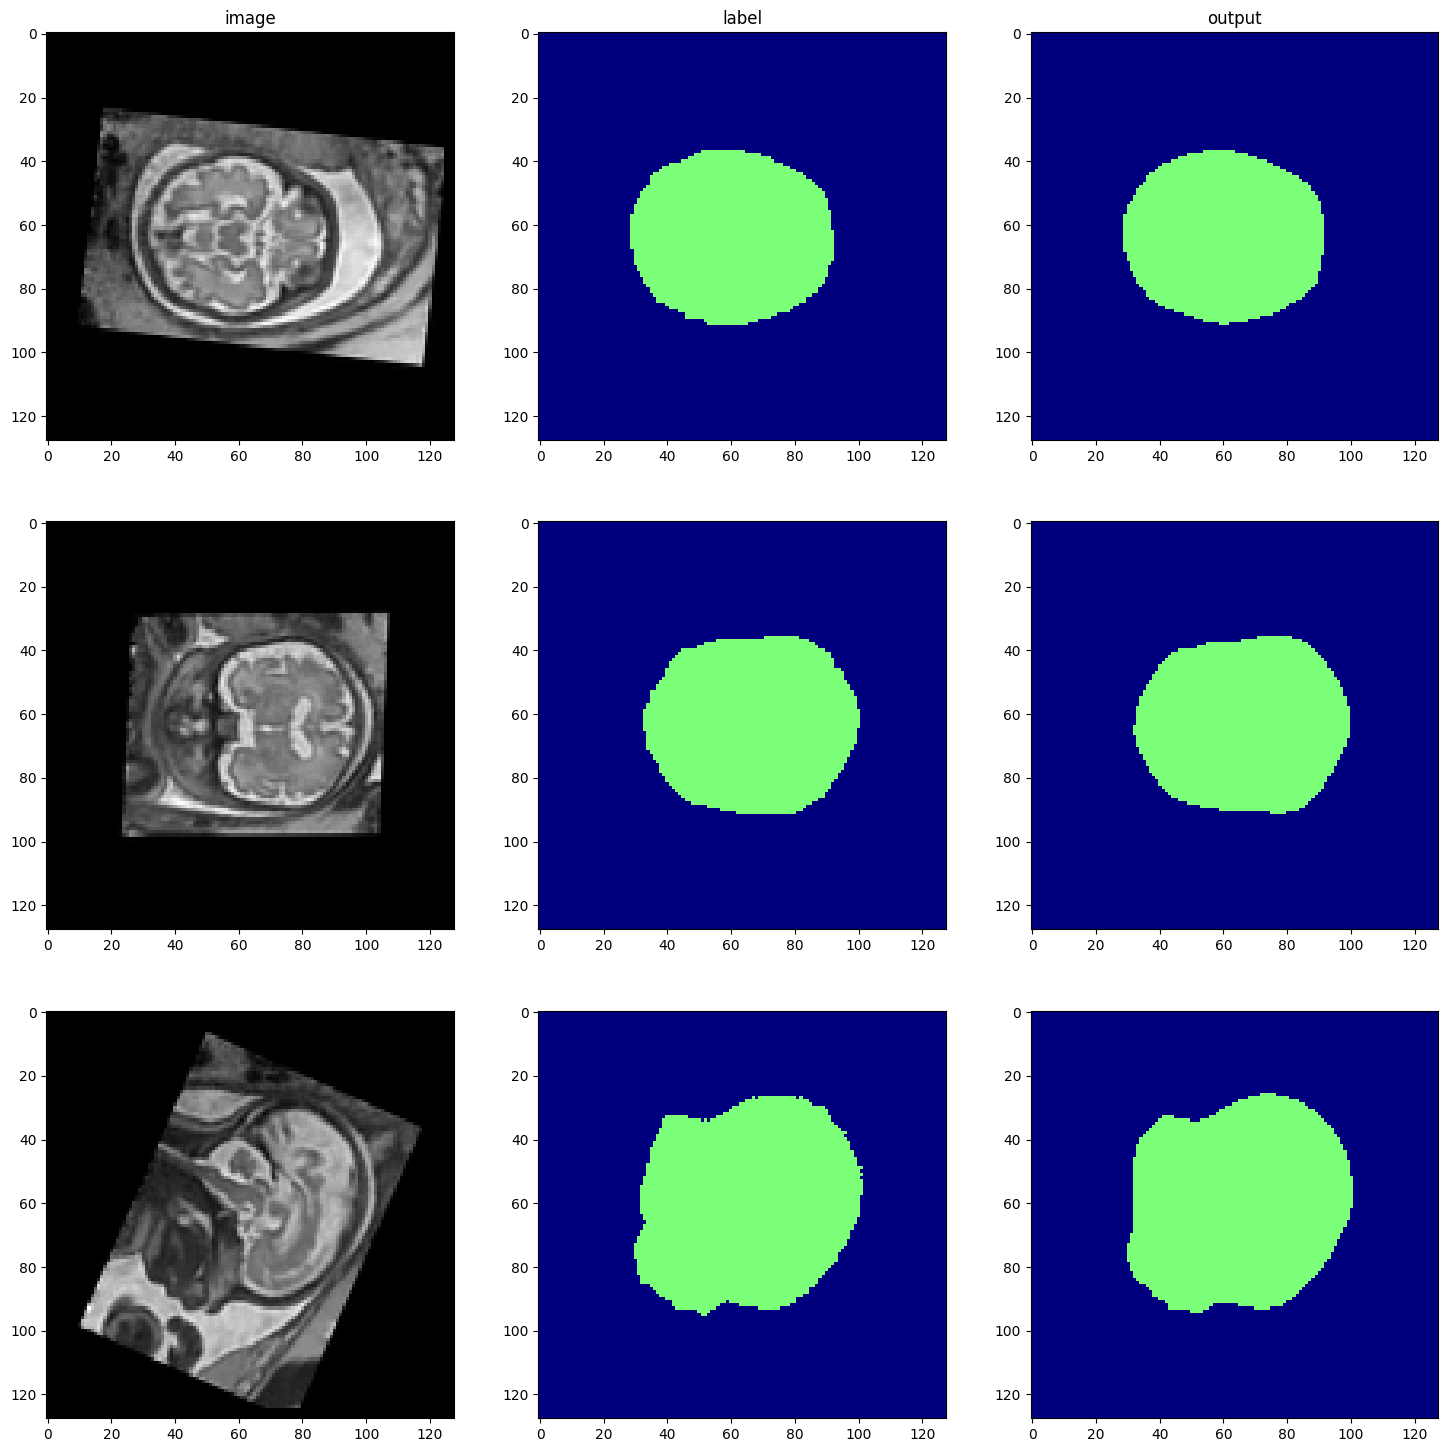

1 335-img.nii.gz
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


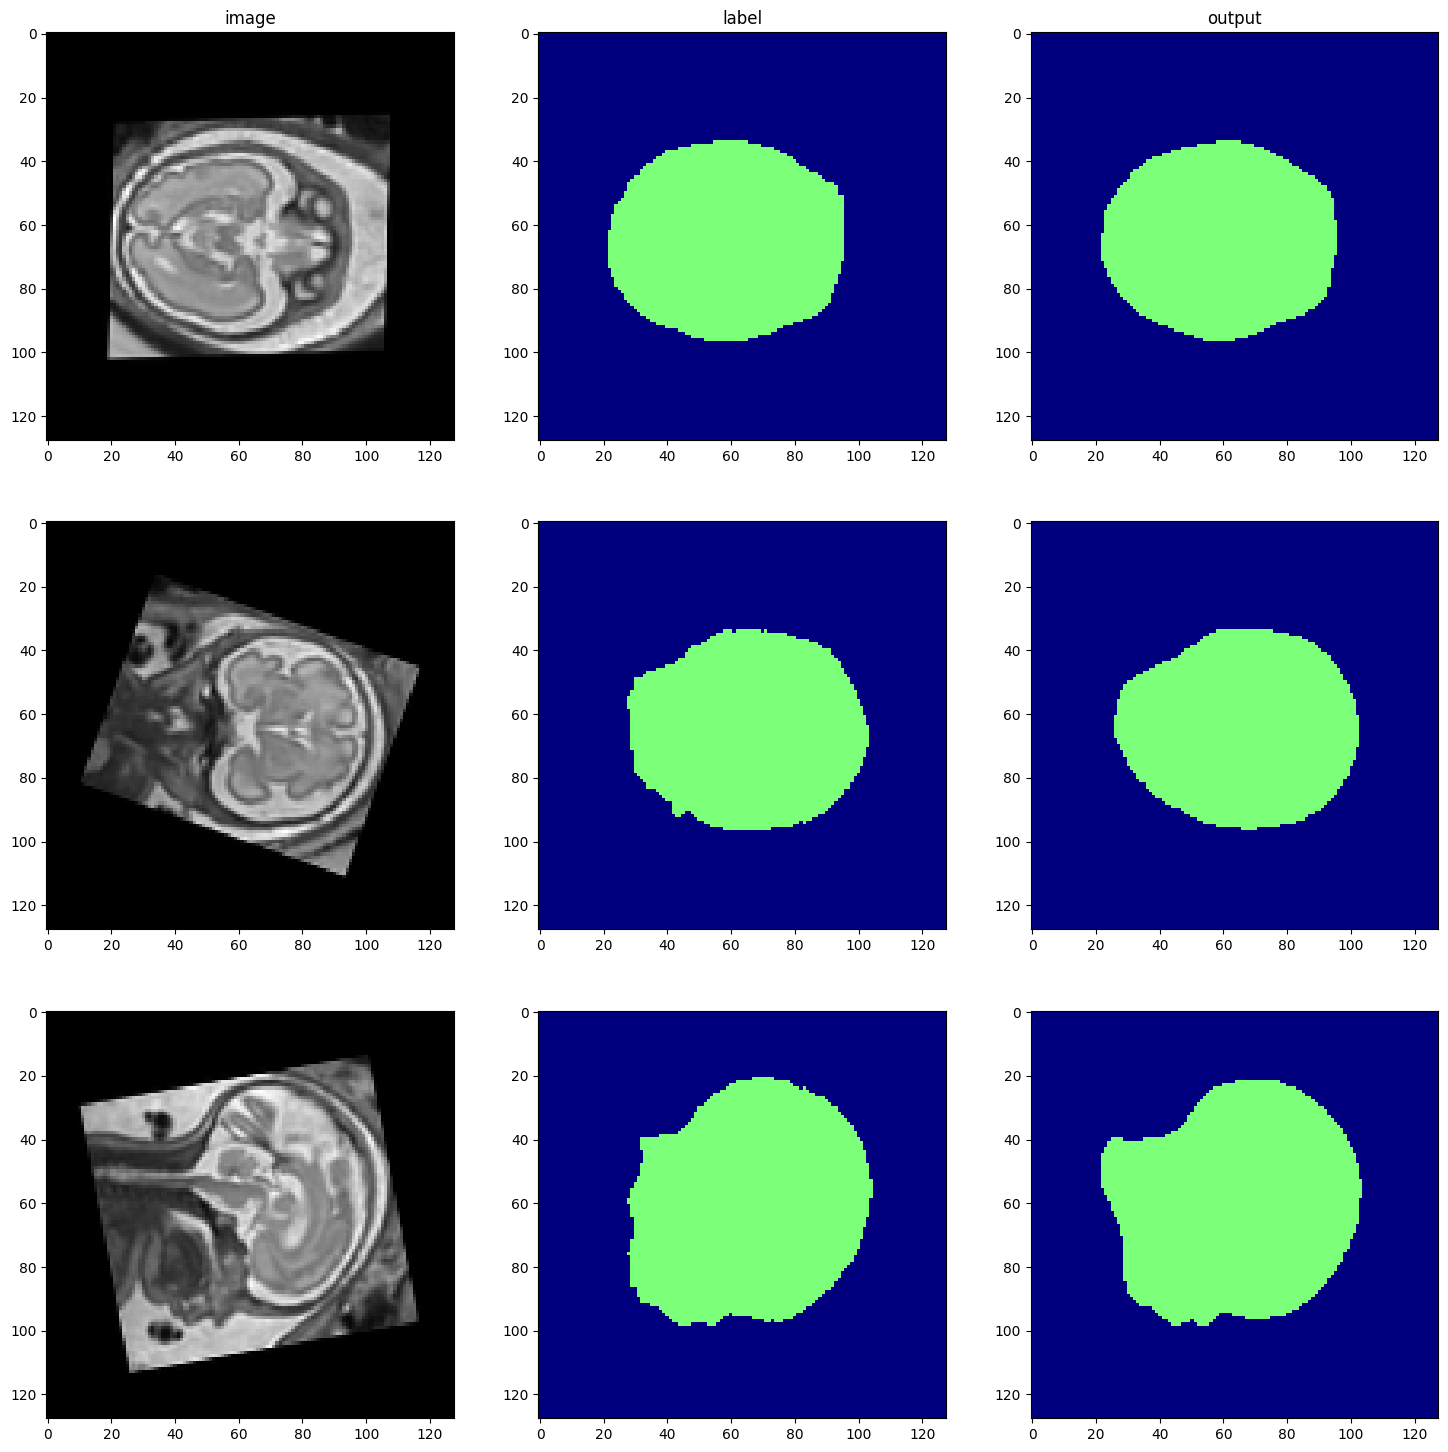

2 426-img.nii.gz
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


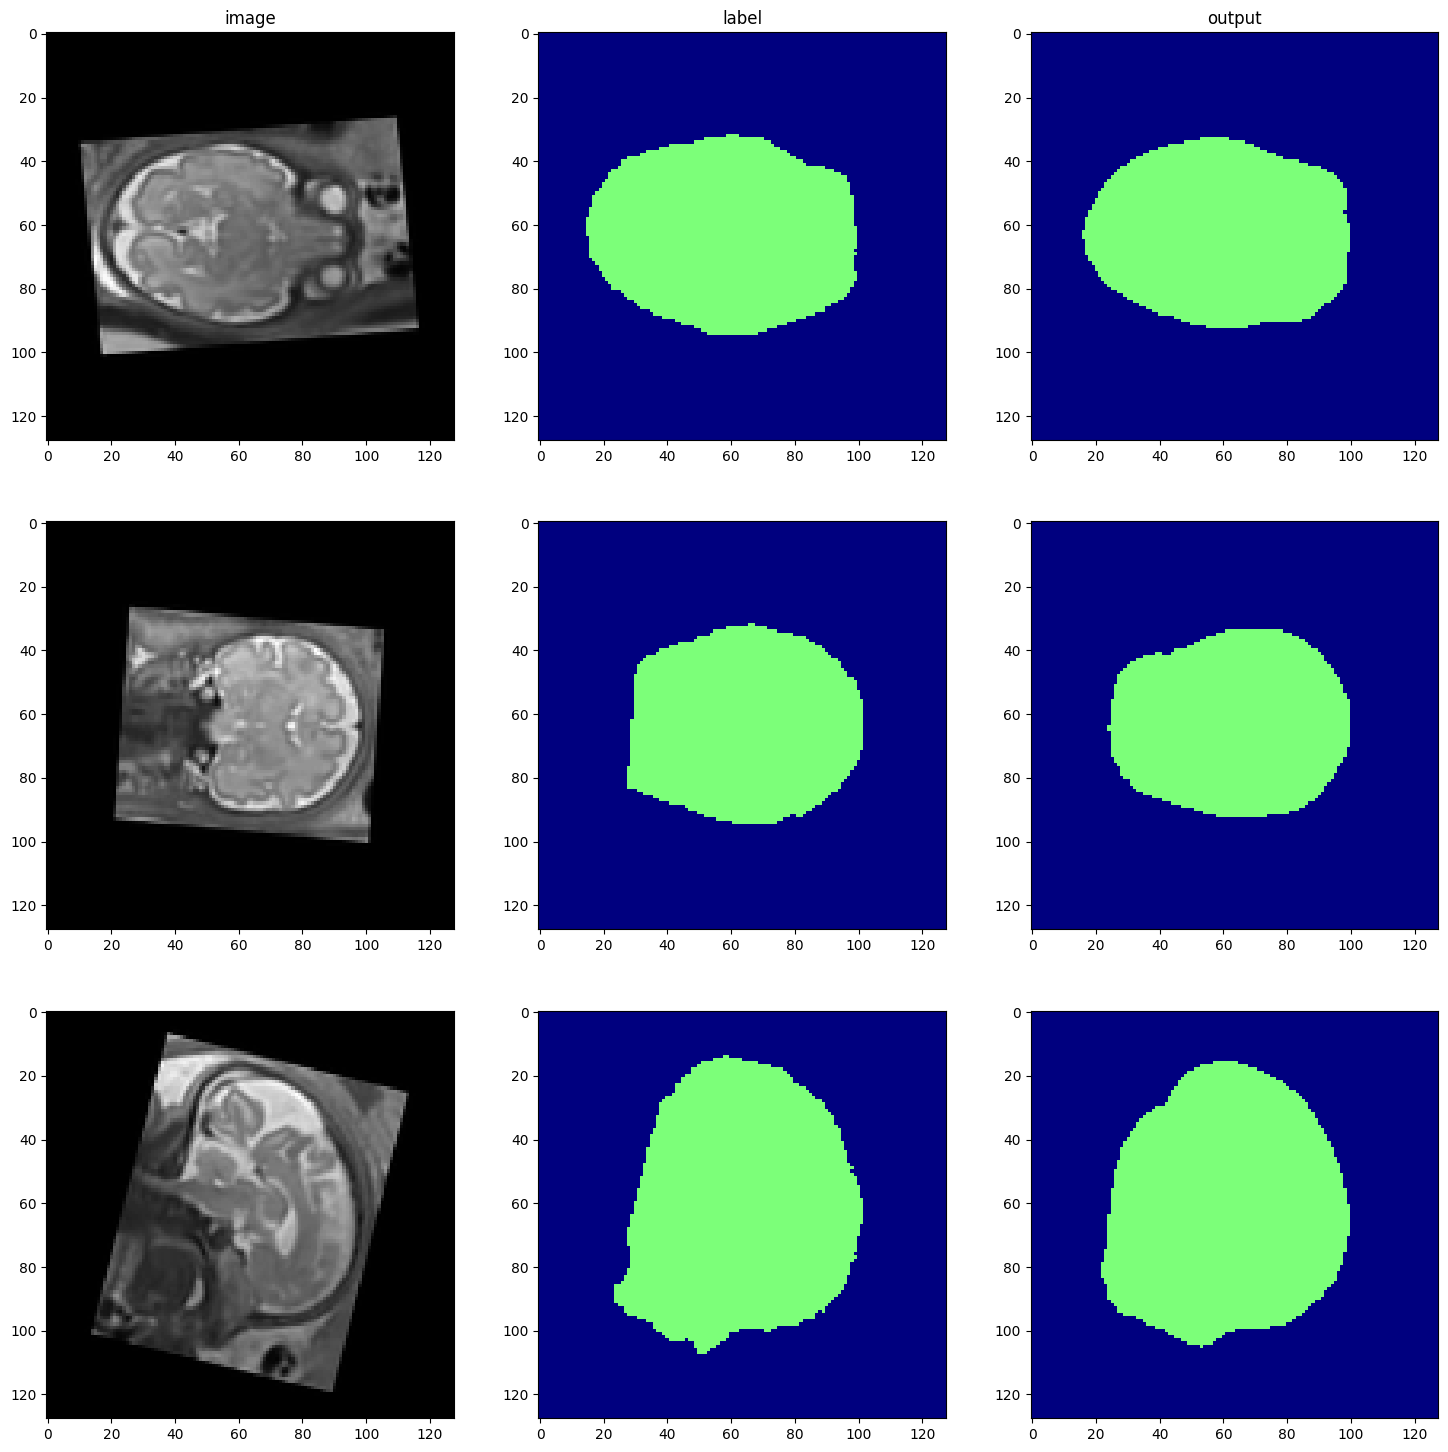

3 342-img.nii.gz
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


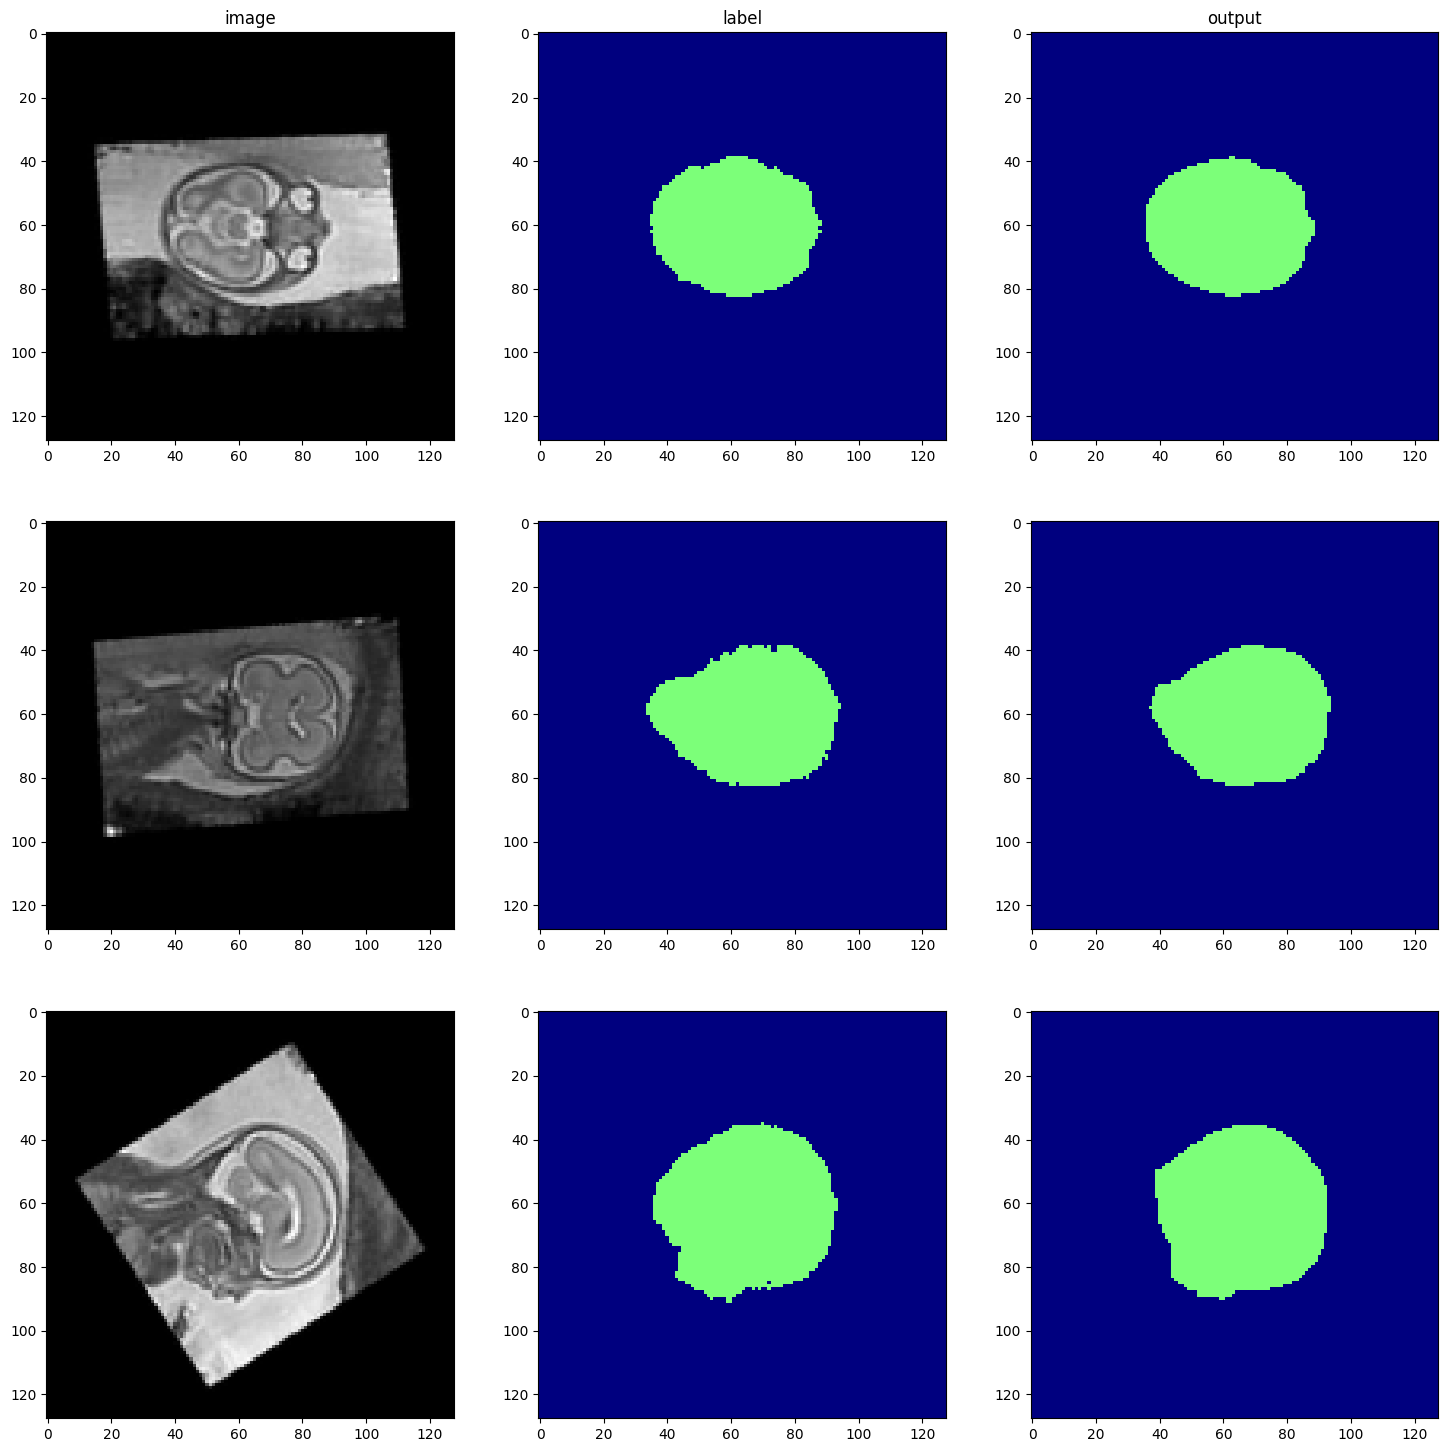

4 435-img.nii.gz
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


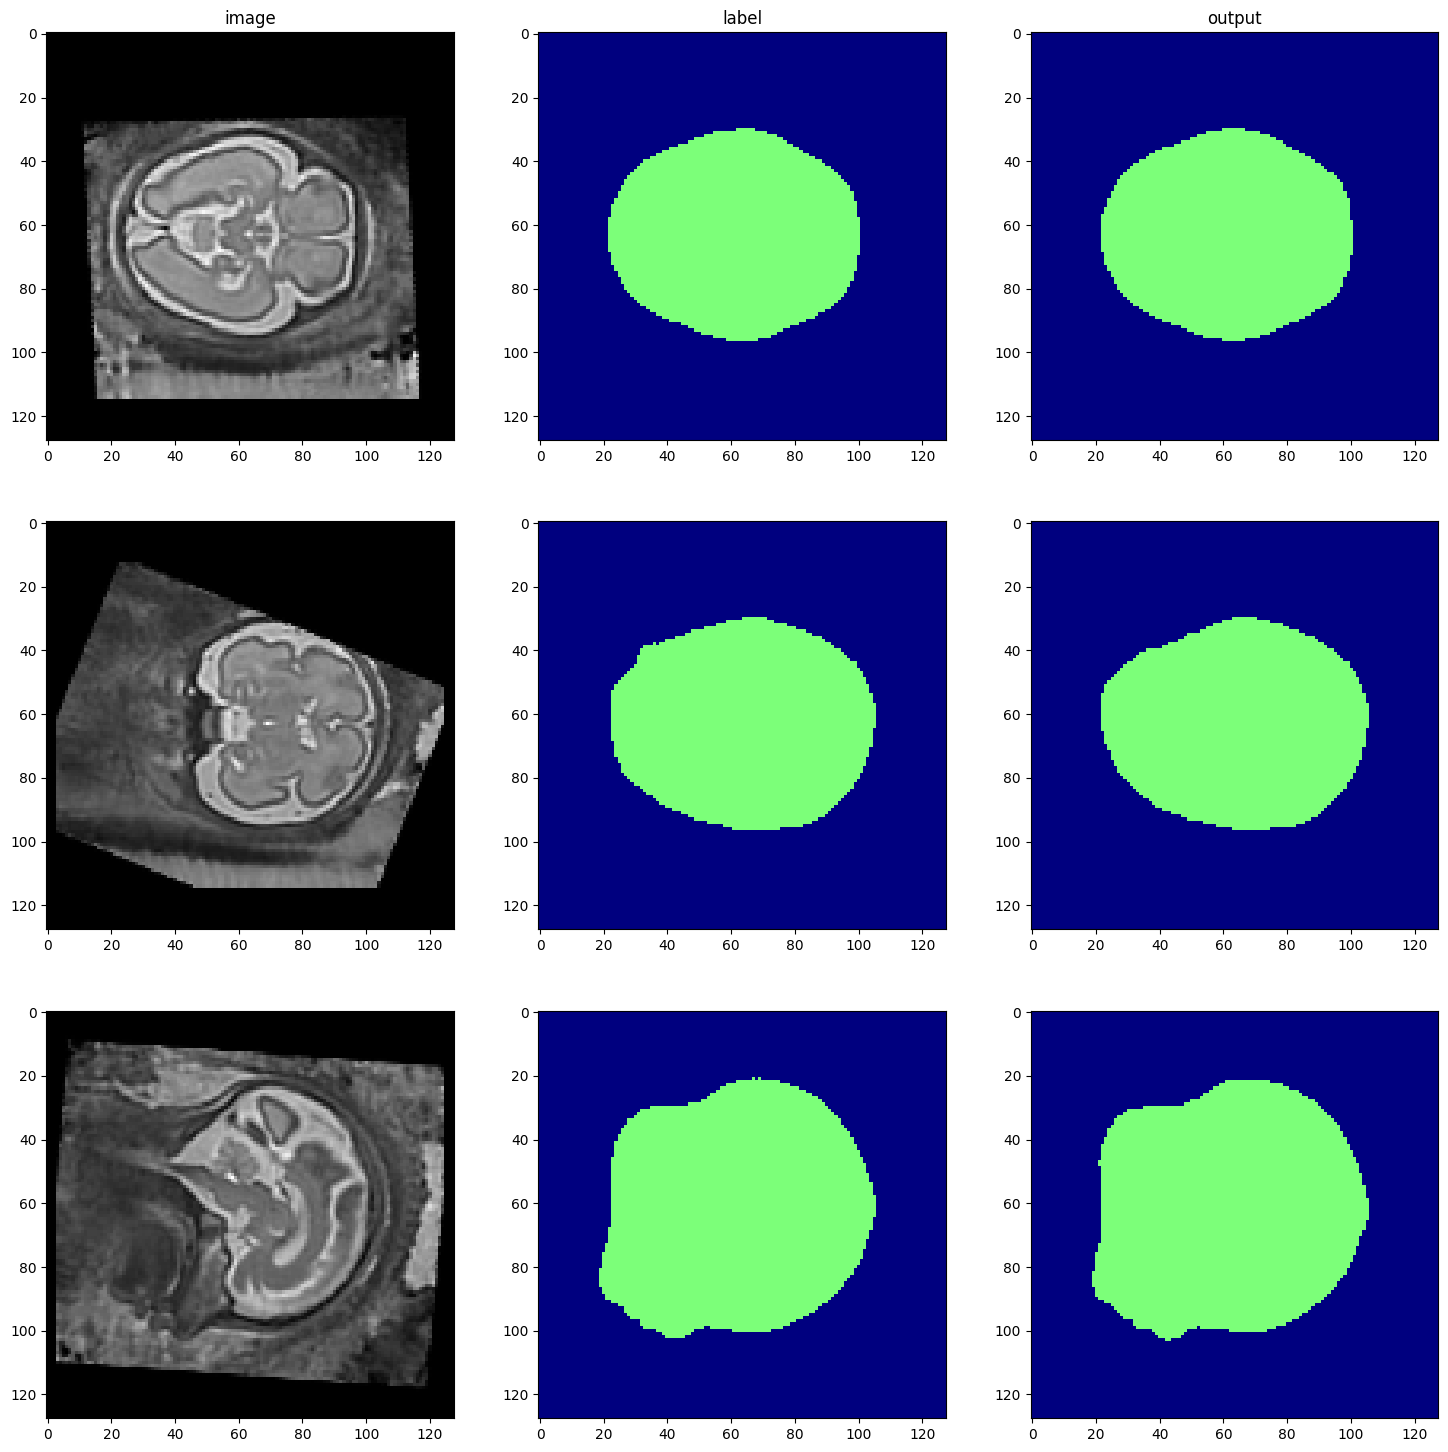

5 hist-136-img.nii.gz
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


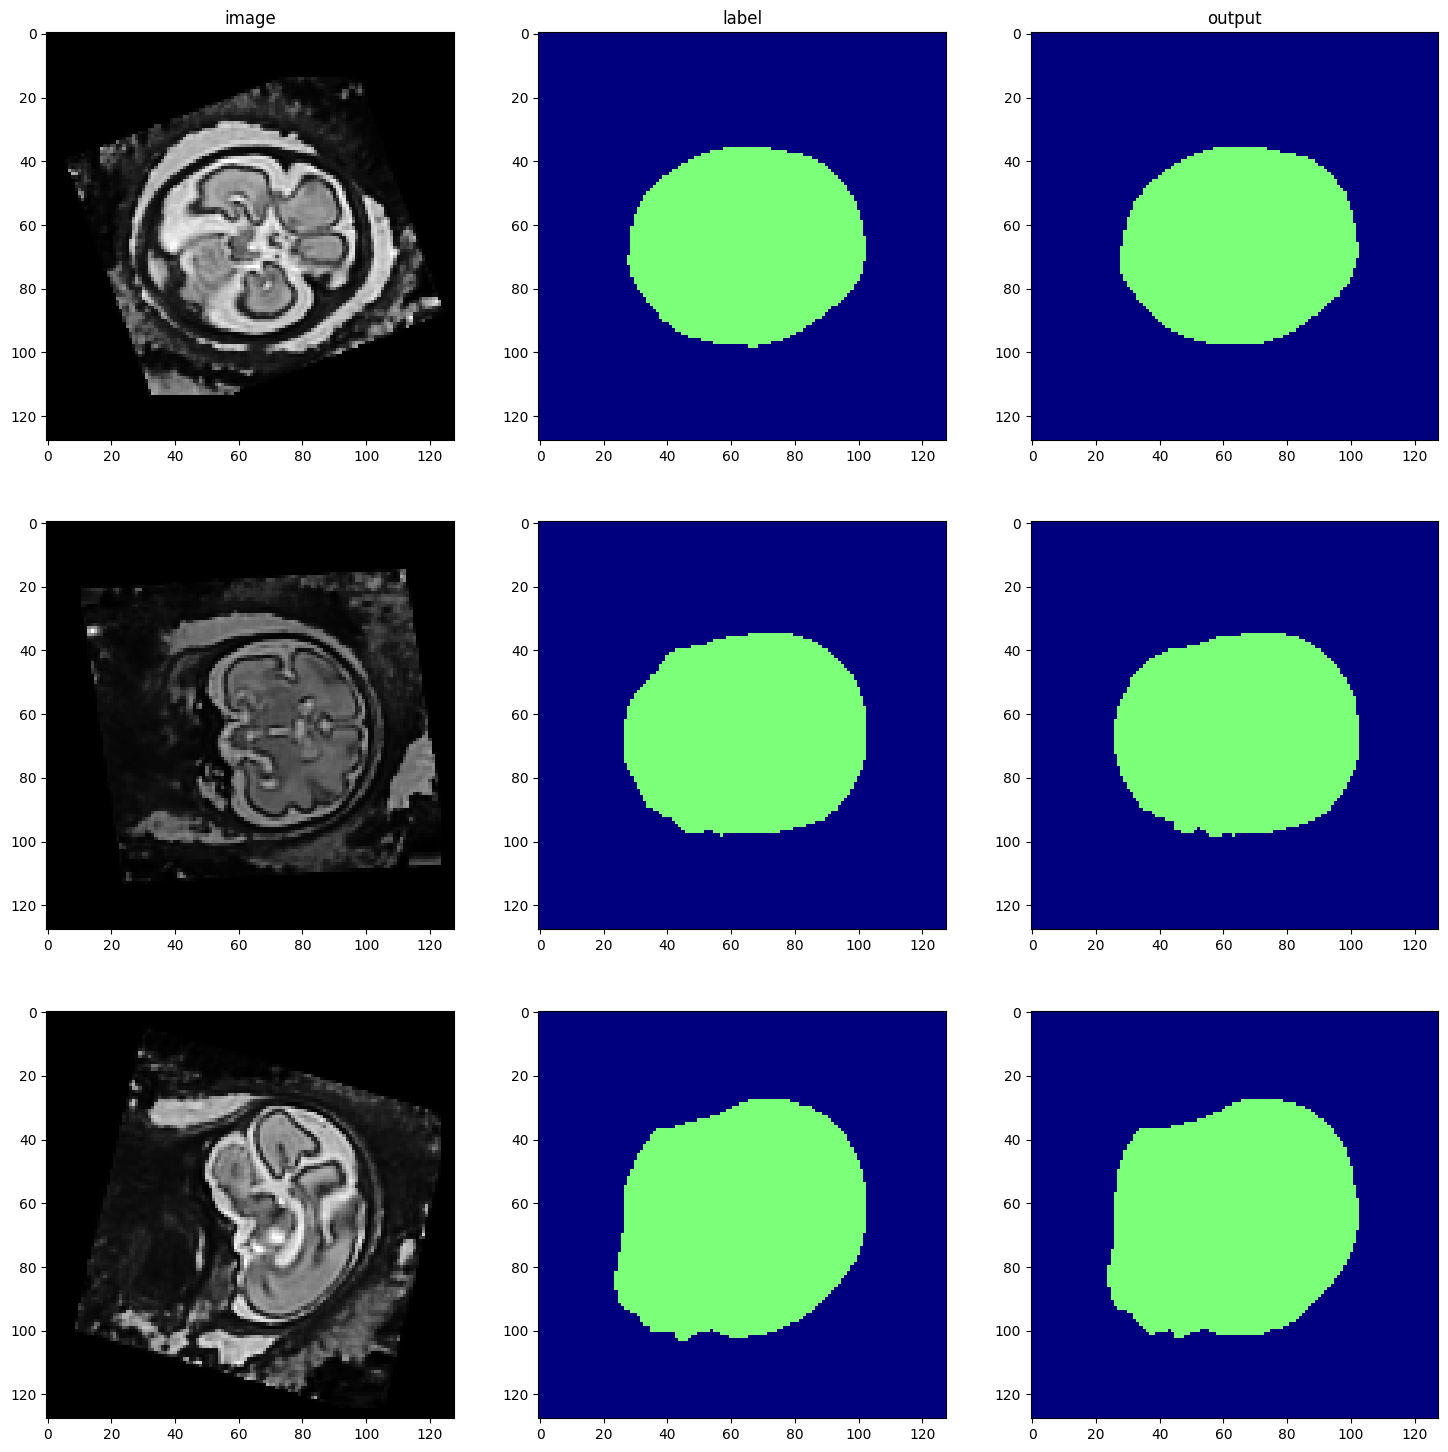

6 hist-214-img.nii.gz
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


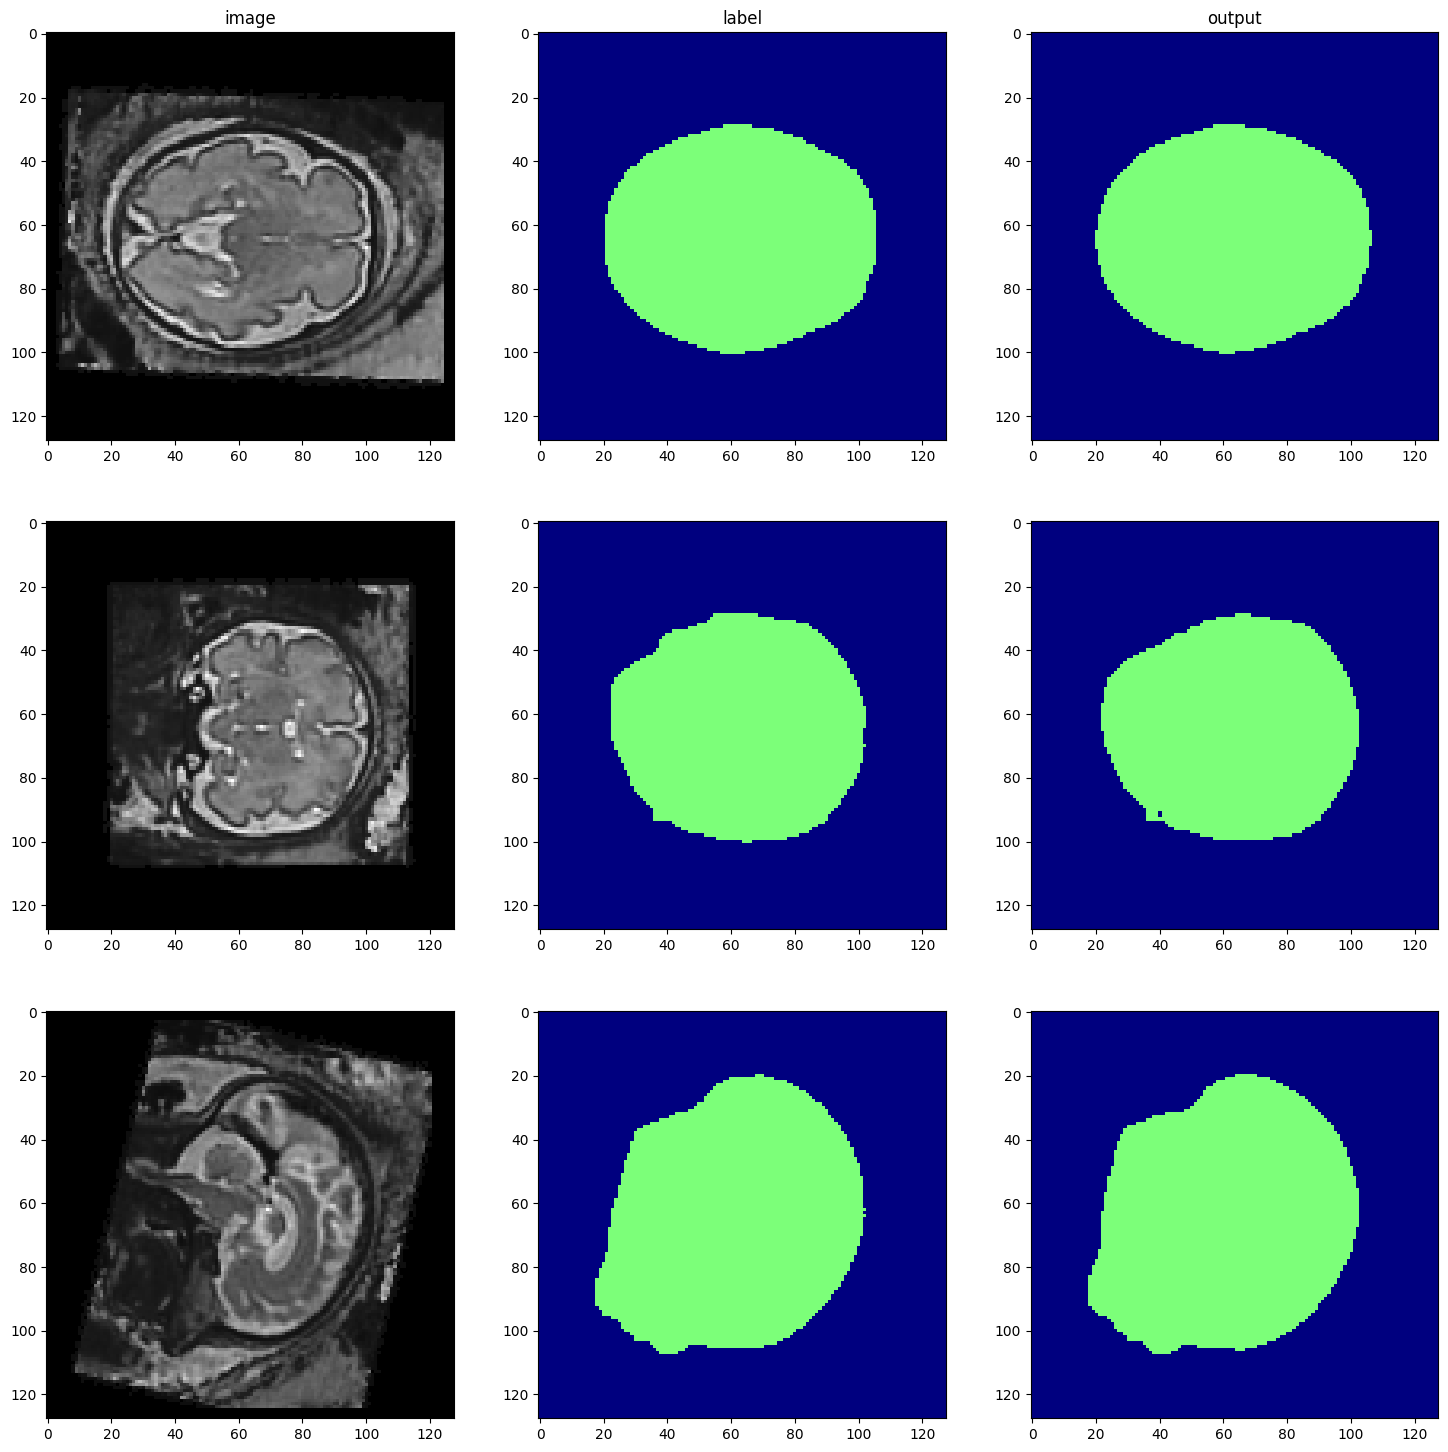

7 hist-236-img.nii.gz
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


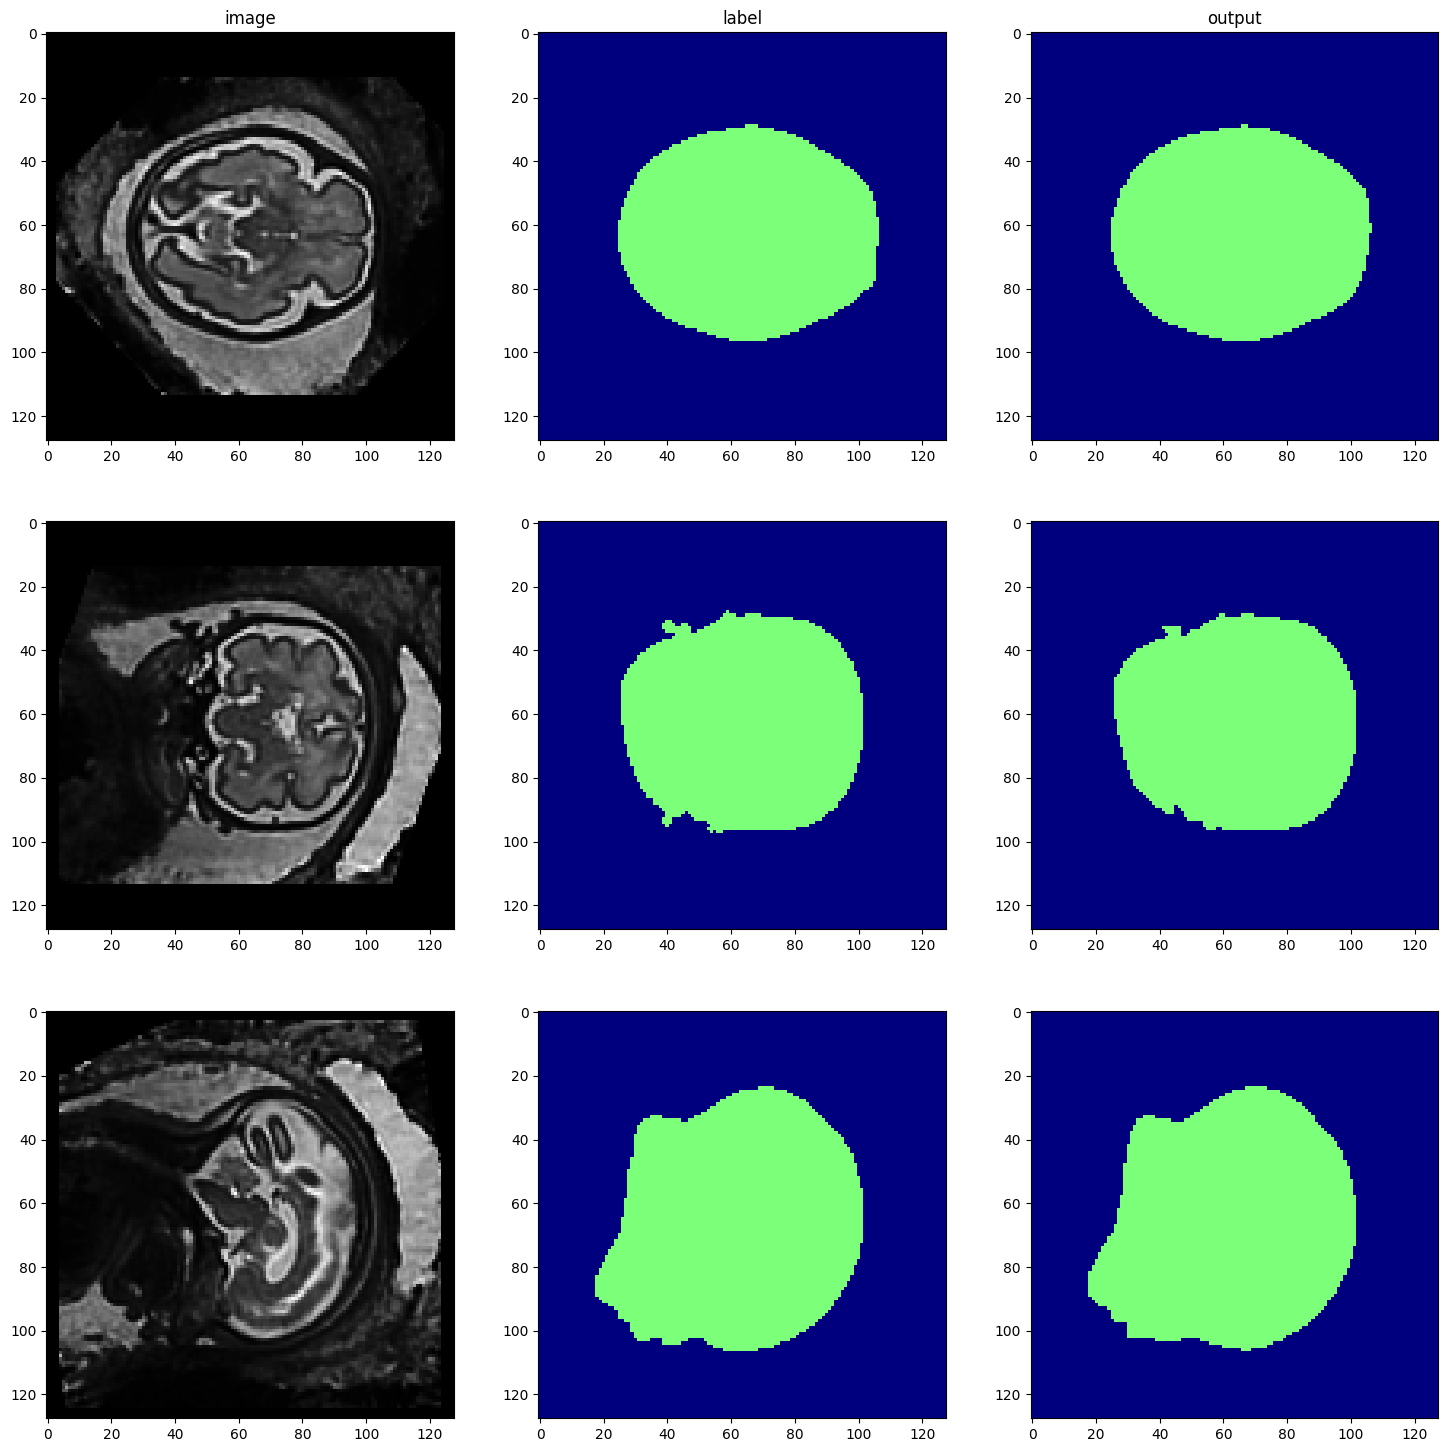

8 hist-253-img.nii.gz
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


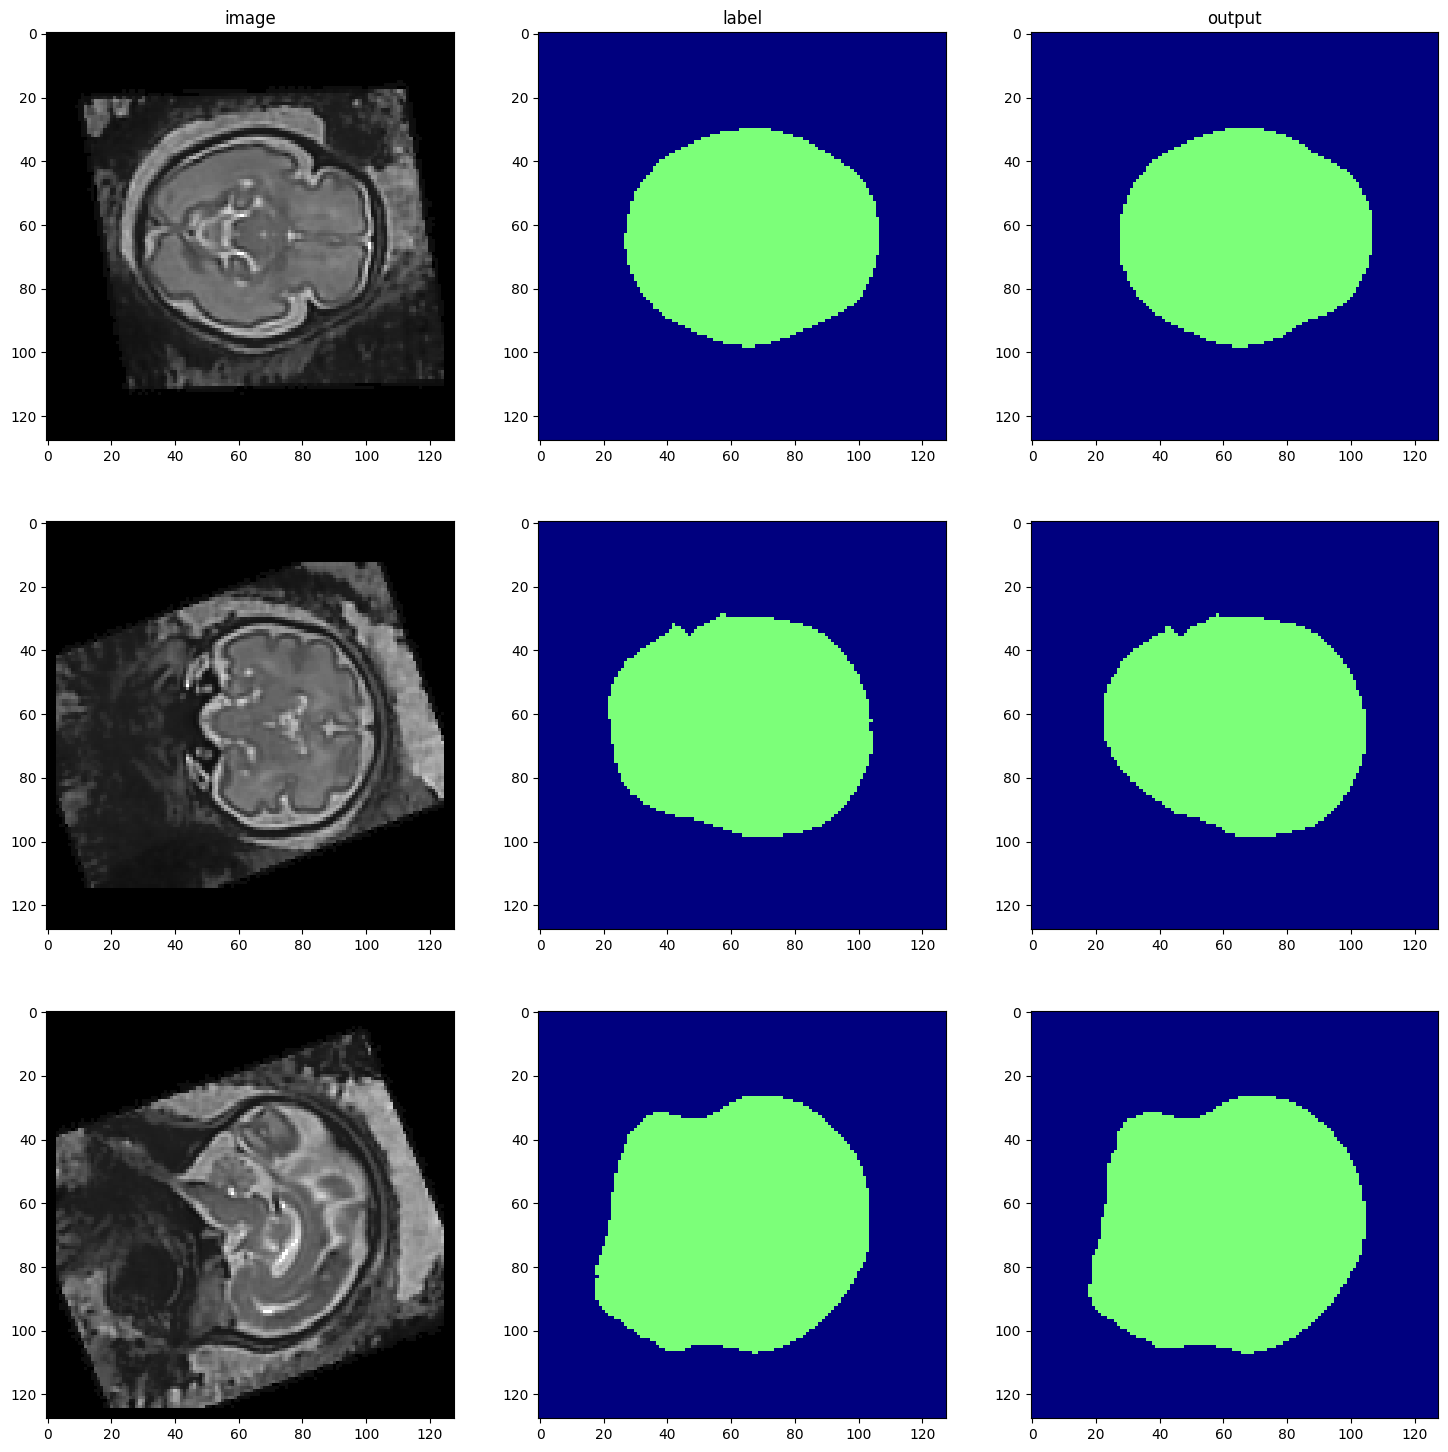

9 hist-275-img.nii.gz
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


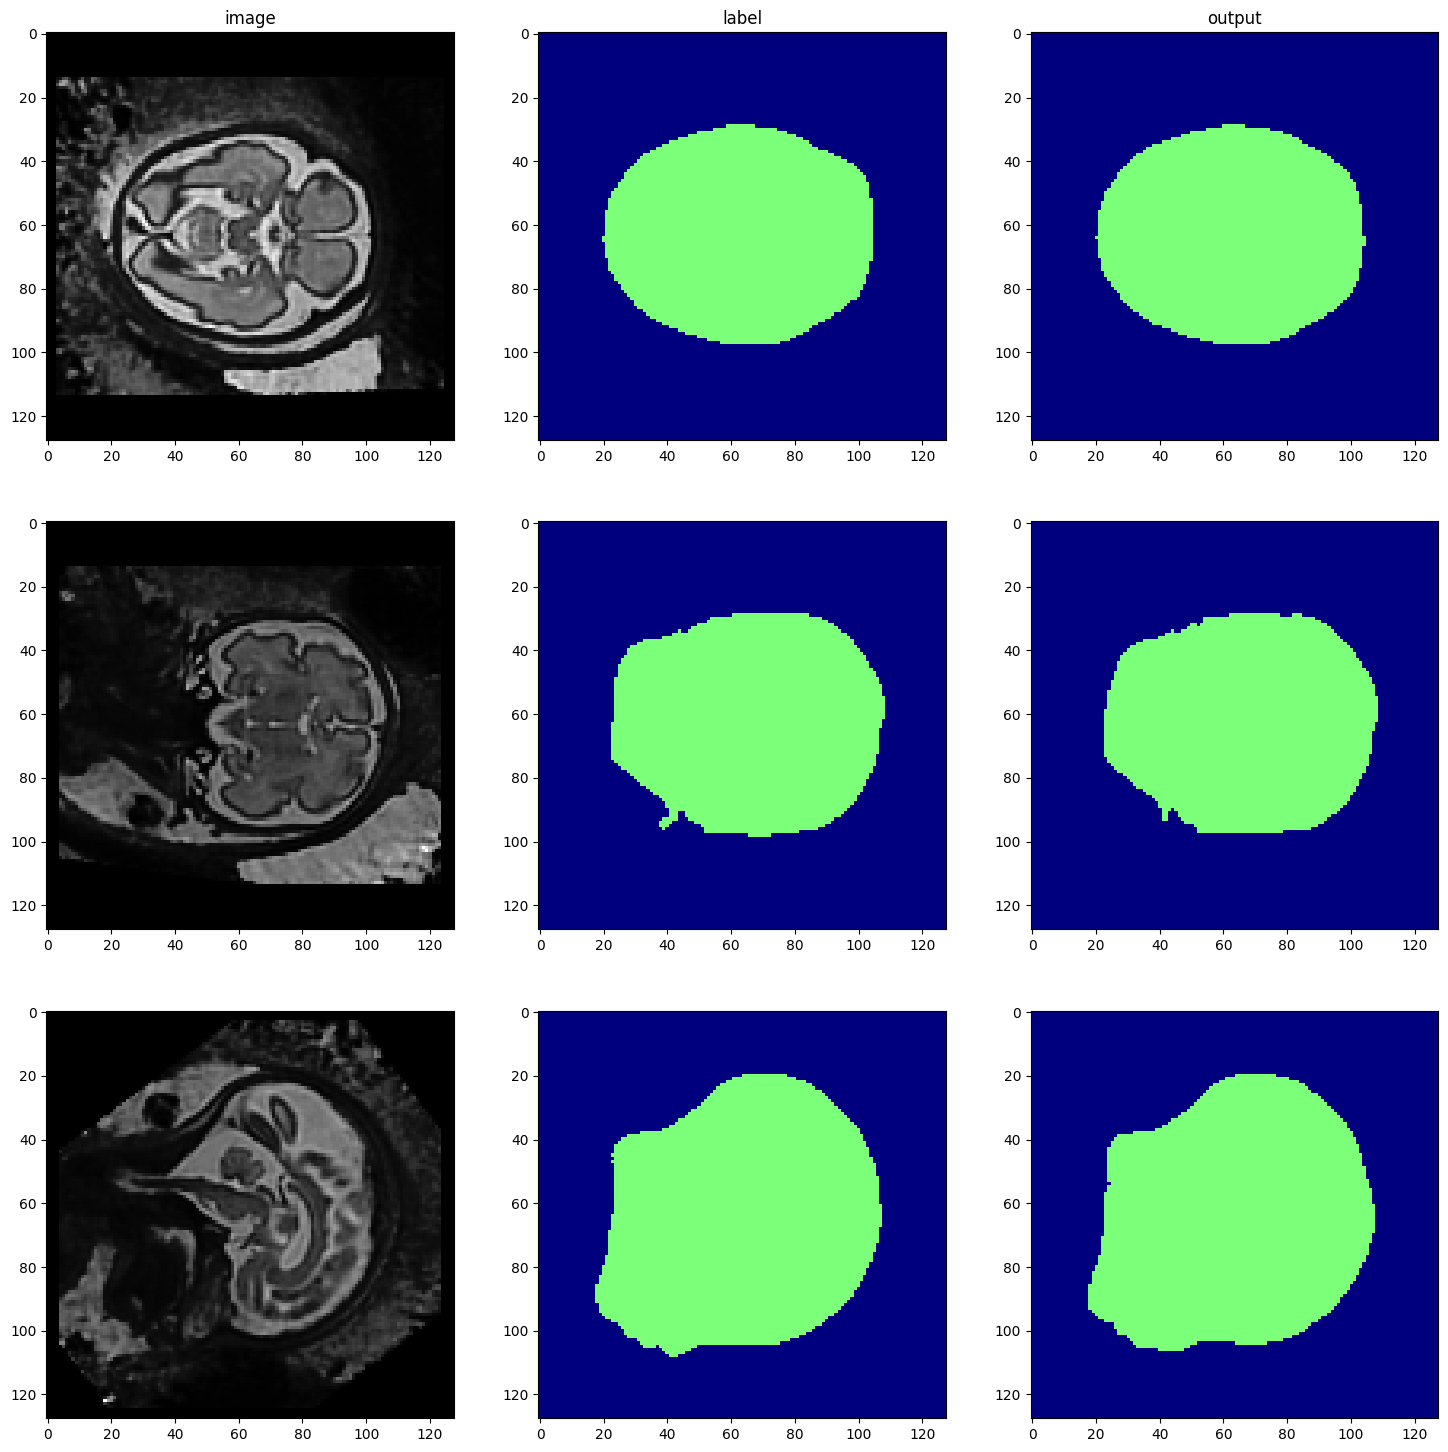

10 hist-292-img.nii.gz
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


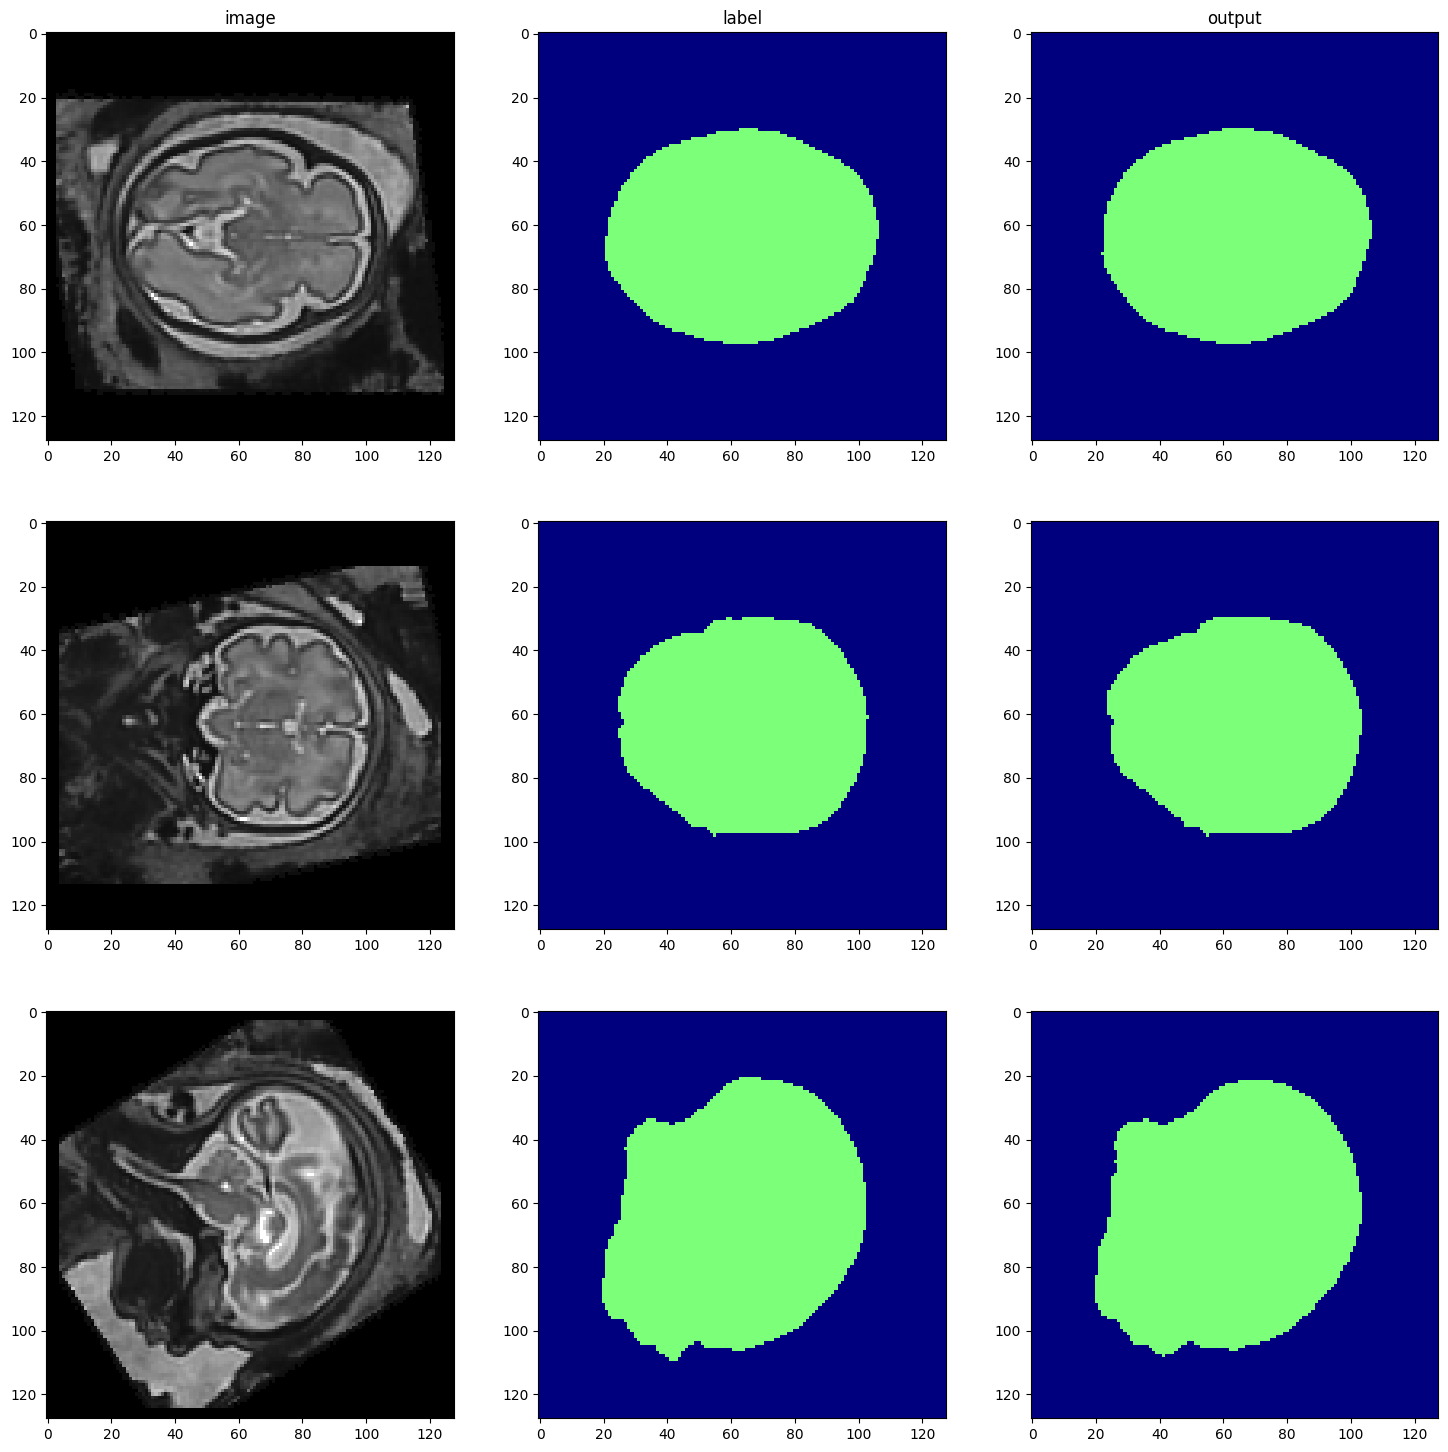

11 hist-355-img.nii.gz
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


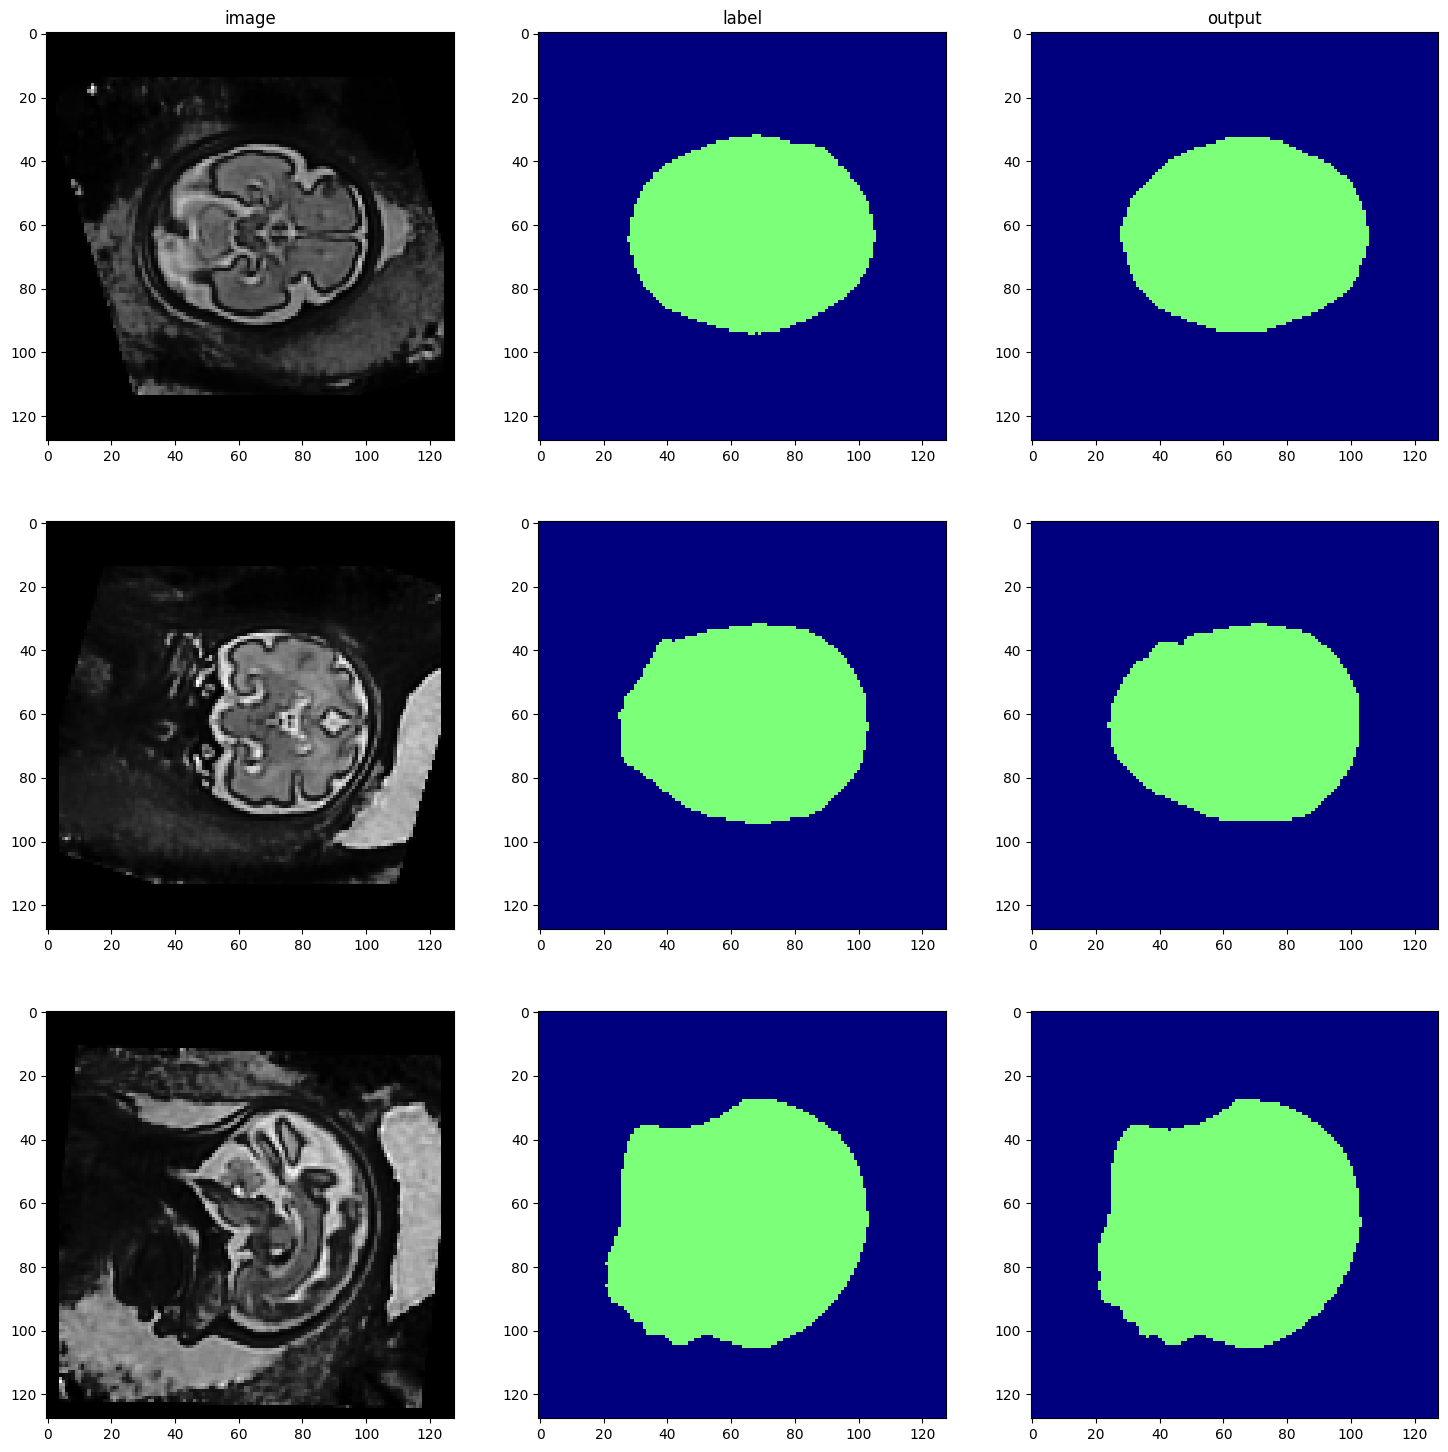

In [ ]:
class_n = class_num
qq=round(img_dim/2)

for x in range(len(val_files_run)):

  case_num = x
  with torch.no_grad():
      img_name = os.path.split(val_ds_run[case_num]["image_meta_dict"]["filename_or_obj"])[1]
      cur_case = val_ds_run[case_num]
      img = cur_case["image"]
      label = cur_case["label"]
      val_inputs = torch.unsqueeze(img, 1).cuda()
      val_labels = torch.unsqueeze(label, 1).cuda()
      val_outputs = sliding_window_inference(
          val_inputs, (img_dim, img_dim, img_dim), 4, model, overlap=0.8
      )

      print(x,img_name)
      print(val_outputs.shape)
      print(val_labels.shape)

      plt.figure("check", (18, 18))
      plt.subplot(3, 3, 1)
      plt.title("image")
      plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, qq], cmap="gray")
      plt.subplot(3, 3, 2)
      plt.title("label")
      plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, qq], vmin=0, vmax=class_n, cmap="jet")
      plt.subplot(3, 3, 3)
      plt.title("output")
      plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, qq], vmin=0, vmax=class_n, cmap="jet")

      plt.subplot(3, 3, 4)
      plt.imshow(val_inputs.cpu().numpy()[0, 0, :, qq, :], cmap="gray")
      plt.subplot(3, 3, 5)
      plt.imshow(val_labels.cpu().numpy()[0, 0, :, qq, :], vmin=0, vmax=class_n, cmap="jet")
      plt.subplot(3, 3, 6)
      plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, qq, :], vmin=0, vmax=class_n, cmap="jet")


      plt.subplot(3, 3, 7)
      plt.imshow(val_inputs.cpu().numpy()[0, 0, qq, :, :], cmap="gray")
      plt.subplot(3, 3, 8)
      plt.imshow(val_labels.cpu().numpy()[0, 0, qq, :, :], vmin=0, vmax=class_n, cmap="jet")
      plt.subplot(3, 3, 9)
      plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, qq, :, :], vmin=0, vmax=class_n, cmap="jet")

      plt.show()

In [ ]:
# save cnn segmentation results for all validation images


res_dir = root_dir + "/" + roi_type + "segresnet_good_aug-results"

isdir = os.path.isdir(res_dir)
if not isdir:
  os.mkdir(res_dir)


for x in range(len(val_files_run)):

  case_num = x
  img_name = val_files_run[case_num]["label"]
  label_name = val_files_run[case_num]["label"]
  case_name = os.path.split(val_ds_run[case_num]["image_meta_dict"]["filename_or_obj"])[1]
  out_name = res_dir + "/cnn-lab-" + case_name
  print(case_num, out_name)

  img_tmp_info = nib.load(img_name)

  with torch.no_grad():
      img_name = os.path.split(val_ds_run[case_num]["image_meta_dict"]["filename_or_obj"])[1]
      img = val_ds_run[case_num]["image"]
      label = val_ds_run[case_num]["label"]
      val_inputs = torch.unsqueeze(img, 1).cuda()
      val_labels = torch.unsqueeze(label, 1).cuda()
      val_outputs = sliding_window_inference(
          val_inputs, (img_dim, img_dim, img_dim), 4, model, overlap=0.8
      )

      out_label = torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, :]
      out_lab_nii = nib.Nifti1Image(out_label, img_tmp_info.affine, img_tmp_info.header)
      nib.save(out_lab_nii, out_name)


0 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_segresnet_good_aug-results/cnn-lab-261-img.nii.gz
1 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_segresnet_good_aug-results/cnn-lab-335-img.nii.gz
2 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_segresnet_good_aug-results/cnn-lab-426-img.nii.gz
3 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_segresnet_good_aug-results/cnn-lab-342-img.nii.gz
4 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_segresnet_good_aug-results/cnn-lab-435-img.nii.gz
5 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_segresnet_good_aug-results/cnn-lab-hist-136-img.nii.gz
6 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_segresnet_good_aug-results/cnn-lab-hist-214-img.nii.gz
7 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_segresnet_good_aug-results/cnn-lab-hist-236-img.nii.gz
8